<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/PyTorch_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Referenced Materials**

* https://amaarora.github.io/2020/09/13/unet.html
* https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
* https://www.youtube.com/watch?v=IHq1t7NxS8k

The majority of this comes from the referenced YouTube video

In [1]:
# Imports
!pip install segmentation-models-pytorch
!pip install -U albumentations

import os
import random
import torch
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm


from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from glob import glob

     |████████████████████████████████| 87 kB 2.9 MB/s 
     |████████████████████████████████| 58 kB 4.6 MB/s 
     |████████████████████████████████| 376 kB 31.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=064e6a9ee7e8ce1e3c704f42f8eb3124c1fb8081058a21e55d6e997773c479a6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3ff9cf8dcec42a3b6a59ee60def572bb5885f5d14d0c5bbebd4792a31b7412d5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 98 kB 3.7 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    

In [2]:
# Initialize Environment
%env SRC_DIR       = sarpol-zahab-tents
%env DATA_DIR      = data/
%env TRAIN_IMG_DIR = data/train_images/
%env TRAIN_LBL_DIR = data/train_labels/
%env VAL_IMG_DIR   = data/val_images/
%env VAL_LBL_DIR   = data/val_labels/
%env PREDICT_DIR   = predictions/

env: SRC_DIR=sarpol-zahab-tents
env: DATA_DIR=data/
env: TRAIN_IMG_DIR=data/train_images/
env: TRAIN_LBL_DIR=data/train_labels/
env: VAL_IMG_DIR=data/val_images/
env: VAL_LBL_DIR=data/val_labels/
env: PREDICT_DIR=predictions/


In [3]:
# Configuration
# Display Limit
DISP_LIMIT    = 1 # Maximum number of images to display
DISP_RESULTS  = True
DISP_SCALE    = 5 # Amount to divide displayed figure scale by

# Directories
SRC_DIR       = os.environ.get("SRC_DIR")
DATA_DIR      = os.environ.get("DATA_DIR")
TRAIN_IMG_DIR = os.environ.get("TRAIN_IMG_DIR")
TRAIN_LBL_DIR = os.environ.get("TRAIN_LBL_DIR")
VAL_IMG_DIR   = os.environ.get("VAL_IMG_DIR")
VAL_LBL_DIR   = os.environ.get("VAL_LBL_DIR")
PREDICT_DIR   = os.environ.get("PREDICT_DIR")

# Images
IMG_FORMAT    = "png"

# Checkpoints
CHECKPOINT    = "checkpoint.pth.tar"

# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE    = 1#5 # Batch size defines the prediction batch; set to 1 if we want individual files
NUM_EPOCHS    = 50 #100
NUM_WORKERS   = 2
IMAGE_HEIGHT  = 512//4
IMAGE_WIDTH   = 512//4
PIN_MEMORY    = True
LOAD_MODEL    = False

# Convolution Settings
C_KERNEL      = 3     # This is the matrix that slides across the image (we define matrix size, so kernel = 3 means 3x3 matrix that slides across the image)
C_STRIDE      = 1     # Number of pixels the kernel slides over the input (how many pixels we move the filter at a time)
C_PADDING     = 1     # Sometimes the filter doesn't perfectly fit the input image, in which case we can pad with 0s or drop the part of the image that didn't fit (called valid padding)
C_BIAS        = False # Bias is false in this case because we're using BatchNorm2d (bias would be canceled by the batch norm, so we set it to false)
R_INPLACE     = True  #

# UNet Settings
IN_CHANNELS   = 3
OUT_CHANNELS  = 1 # We're doing binary image segmentation (because our masks are black and white), so we can output a single channel
U_FEATURES    = [64, 128, 256, 512] # Features come from the architecture (the number above the boxes)

# UNet Pool Settings
P_KERNEL      = 2
P_STRIDE      = 2

# Final layer kernel size
F_KERNEL      = 1 # Because we're outputting the final image here

In [4]:
# Initialize Directories
%%bash
echo "Working in Directory: $(pwd)"

if [ -d 'sample_data' ]; then
  rm -r sample_data
fi

if [ ! -d $SRC_DIR ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
fi

if [ ! -d $TRAIN_IMG_DIR ]; then
  mkdir -p $TRAIN_IMG_DIR
fi

if [ ! -d $TRAIN_LBL_DIR ]; then
  mkdir -p $TRAIN_LBL_DIR
fi

if [ ! -d $VAL_IMG_DIR ]; then
  mkdir -p $VAL_IMG_DIR
fi

if [ ! -d $VAL_LBL_DIR ]; then
  mkdir -p $VAL_LBL_DIR
fi

if [ ! -d $PREDICT_DIR ]; then
  mkdir -p $PREDICT_DIR
fi

Working in Directory: /content


Cloning into 'sarpol-zahab-tents'...


In [5]:
# Print Device
print("Device: ", DEVICE)

Device:  cuda


In [6]:
# Preparing Data
def load(path):
  return np.array([np.asarray(Image.open(path)) for path in sorted(glob(path))])

src_imgs = load("{}/data/images/*".format(SRC_DIR))
src_lbls = load("{}/data/labels/*".format(SRC_DIR))

dataset = []
# Dataset Structure:
# [
#   0:{
#     img:  image
#     lbl:  label
#     filename: {img: 0.png, lbl: 0.png}
#   },
#   1:{}, 2:{}, n:{}
# ]

if src_imgs.shape[0] == src_lbls.shape[0]:
  n = src_lbls.shape[0]

  for index in range(n):
    dataset.append({
      "img":Image.fromarray(src_imgs[index]),
      "lbl":Image.fromarray(src_lbls[index]),
      "filename":{
        "img":f"{index}.{IMG_FORMAT}",
        "lbl":f"{index}.{IMG_FORMAT}"
      }
    })

def save_data(data, val=False):
  img_dir = TRAIN_IMG_DIR
  lbl_dir = TRAIN_LBL_DIR

  if val:
    img_dir = VAL_IMG_DIR
    lbl_dir = VAL_LBL_DIR

  data["img"].save(f"{img_dir}/{data['filename']['img']}")
  data["lbl"].save(f"{lbl_dir}/{data['filename']['lbl']}")

for data in dataset:
  save_data(data, val=bool(random.getrandbits(1))) # TODO: will need a way to skew the results of random so we can distribute by percentages

In [7]:
# Cleanup
%%bash
if [ -d $SRC_DIR ]; then
  rm -r $SRC_DIR
fi

**U-Net Architecture:**

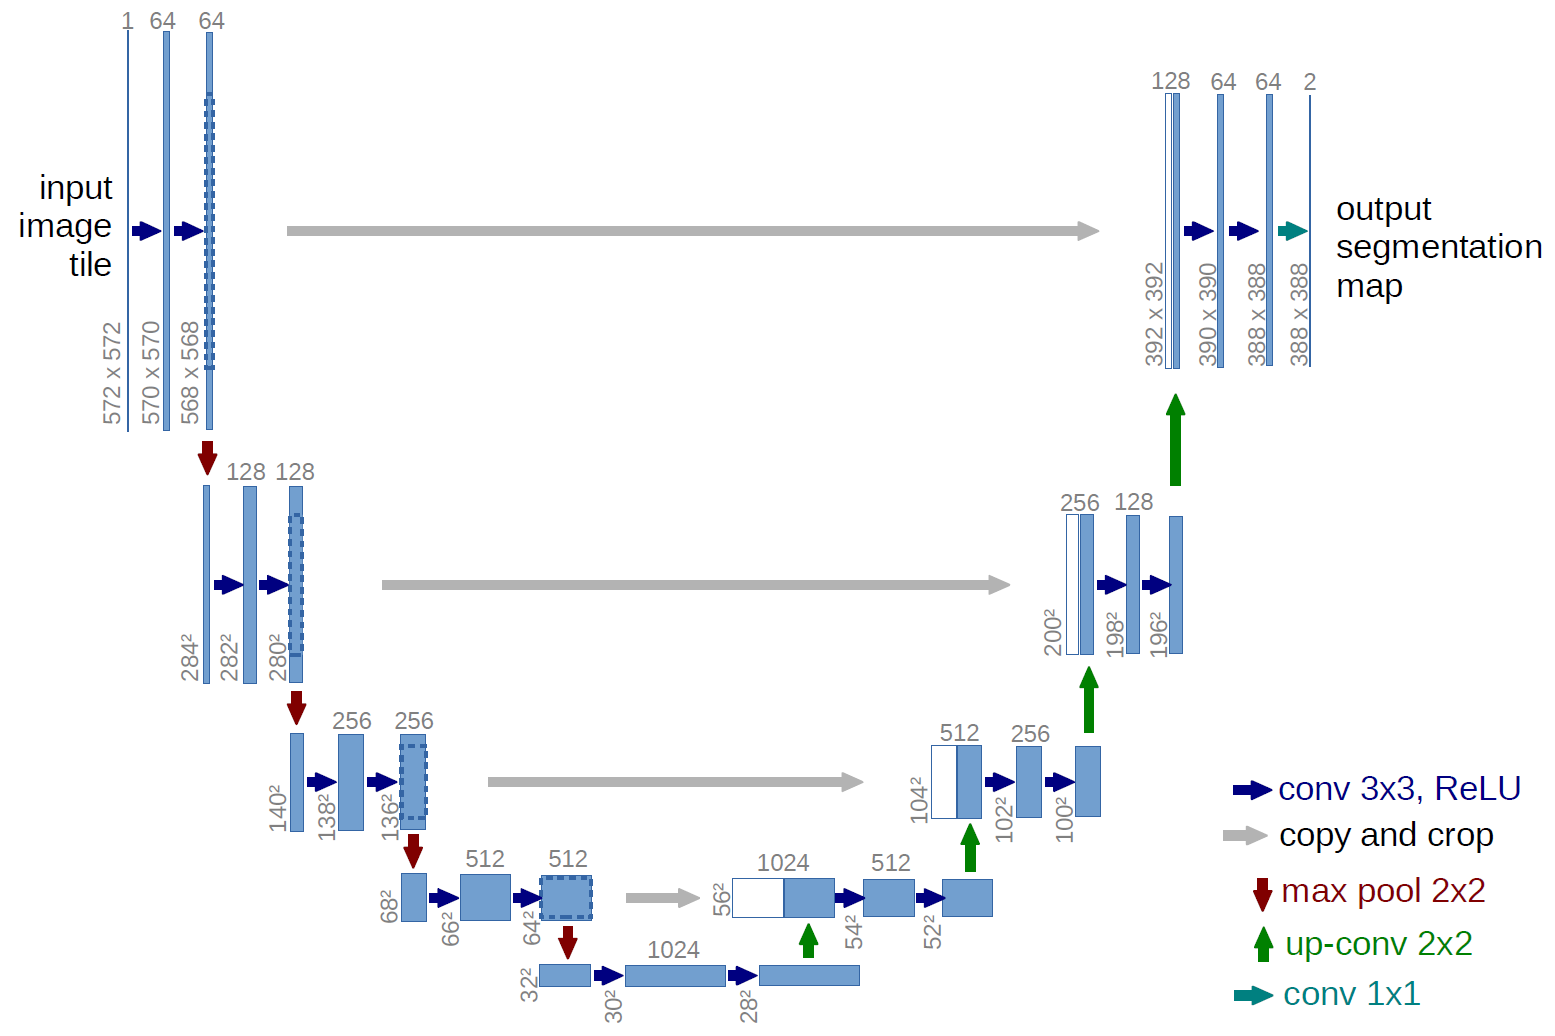

The first half of the architecture is the down-sampling process. At each stage, two 3x3 convolutions are used. The output is then pooled and becomes the input for the next 3x3 convolution and so on, until the bottom of this diagram is reached.

The second half of the architecture is the up-sampling process, which is a reflection of the down-sampling process.

In [8]:
# model.py


# # Referenced https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148
# # Convolution Settings
# C_KERNEL  = 3     # This is the matrix that slides across the image (we define matrix size, so kernel = 3 means 3x3 matrix that slides across the image)
# C_STRIDE  = 1     # Number of pixels the kernel slides over the input (how many pixels we move the filter at a time)
# C_PADDING = 1     # Sometimes the filter doesn't perfectly fit the input image, in which case we can pad with 0s or drop the part of the image that didn't fit (called valid padding)
# C_BIAS    = False # Bias is false in this case because we're using BatchNorm2d (bias would be canceled by the batch norm, so we set it to false)
# R_INPLACE = True  #

# # UNet Settings
# IN_CHANNELS  = 3
# OUT_CHANNELS = 1 # We're doing binary image segmentation (because our masks are black and white), so we can output a single channel
# U_FEATURES     = [64, 128, 256, 512] # Features come from the architecture (the number above the boxes)

# # UNet Pool Settings
# P_KERNEL = 2
# P_STRIDE = 2

# # Final layer kernel size
# F_KERNEL = 1 # Because we're outputting the final image here


# from https://www.youtube.com/watch?v=IHq1t7NxS8k
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential (
        nn.Conv2d(in_channels, out_channels, C_KERNEL, C_STRIDE, C_PADDING, bias=C_BIAS), # This is a same convolution (input height*width = output height*width)
        nn.BatchNorm2d(out_channels), # BatchNorm accelerates training by normalizing inputs by re-centering and re-scaling
        nn.ReLU(inplace=R_INPLACE), # ReLU is Rectified Linear Unit; essentially it makes it so negative inputs are discarded and positive inputs are passed through

        # Now we do this a second time but with out_channels to out_channels
        nn.Conv2d(out_channels, out_channels, C_KERNEL, C_STRIDE, C_PADDING, bias=C_BIAS),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=R_INPLACE),
    )

  def forward(self, x):
    return self.conv(x)

# DoubleConv is everything in the first node of the architecture (before pooling)

class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=U_FEATURES):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList() # Stores the convolutional layers; it's a list, but using ModuleList lets us use BatchNorm2d
    self.pool = nn.MaxPool2d(kernel_size=P_KERNEL, stride=P_STRIDE) # Pooling layer will be used inbetween, in forwarding method
    # Note that the pooling layer will require out inputs to be perfectly divisible by 2 because we're doing a stride of 2
    # Example: 161 x 161 -> MaxPool -> 80 x 80 -> Upsample -> 160 x 160; in this case, we couldn't concatinate the two as they need the same width and height for concat (161x161 is input, 160x160 is output)
    # If input is perfectly dividible by 16 then this issue won't happen (16 because its 4 steps, all dividing by 2 (16/(4*2) = 2))
    # In order to keep the system general, we can either pad the image or crop the image so that it works even if image size isn't perfectly divisible by 16


    # Down-Sampling part of UNet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature)) # Mapping some input (in the UNet architecture example, it maps 1 to 64 for the first node)
      in_channels = feature

    # Up-Sampling Part of UNet
    # At 10:20 or so in the video he mentions transposed convoltions that may be a better method to this part, but we'll use similar approach to UNet paper for now
    # We're using the reversed list of features because we're going from the bottom up now
    for feature in reversed(features):
      
      # In_channels is feature*2 here, output is feature
      self.ups.append(
          nn.ConvTranspose2d( 
              feature*2, feature, kernel_size=P_KERNEL, stride=P_STRIDE
          )
      )
      self.ups.append(DoubleConv(feature*2, feature)) # Because we go up then do two convs then go up then do two convs etc

    # Bottom Layer
    self.bottleneck = DoubleConv(features[-1], features[-1]*2) # We're using features[-1] because we want the bottom feature

    # Now we do 1x1 conv which doesn't change height or width just number of channels
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=F_KERNEL)
  

  def forward(self, x):
    skip_connections = [] # We skip connections for each stage in the architecture, as we use this part later on
    
    # This loop does all the down-sampling steps until the final step just before the bottom layer (aka bottleneck)
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1] # we wanna go backwards in order when we're doing our concatination; the highest resolution image is the first one; to make things easier, we'll just reverse this list

    # We're using a step of 2 here because we're going up then double conv each iteration
    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x) # doing ConvTranspose2d here
      skip_connection = skip_connections[i//2] # // is integer division; we're doing a step of one ordering here

      # Dealing with images that are not perfectly dividible
      # TODO: perhaps we should look into scaling instead of cropping or padding, or perhaps we should scale before we put the image into the system, so that this is not relevant?
      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connections.shape[2:]) # we're taking out height and width here; basically, we're resizing the image if it doesn't fit

      concat_skip = torch.cat((skip_connection, x), dim=1) # dim 1 is the channel dimension; we're concationating these things along the channel dimension
      x = self.ups[i+1](concat_skip) # running it through a double conv
    
    return self.final_conv(x)




# Testing the implementation thus far
def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == "__main__":
   test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [9]:
# TentDataset

# IMG_FORMAT       = 'png'
# IMG_TYPE         = 'RGB'
# IMG_SIZE         = 512

# SRC_DIR          = environ.get("SRC_DIR")
# DATA_DIR         = Path(f'data/dataset/')
# TRAIN_IMG_DIR    = DATA_DIR/'train'
# TRAIN_LBL_DIR    = DATA_DIR/'mask'



# Now we'll set up data loading part
# Starts around 22:30 in the video https://www.youtube.com/watch?v=IHq1t7NxS8k

# Data directory should be in the format:
# data
#   train_images
#   train_masks
#   val_images
#   val_masks

# Samples should be divided up between these directories (though we may be able to just use a dictionary for this instead so we can have easier control)


# TODO: might want to change how we handle the image and mask directories
class TentDataset(Dataset):
  def __init__(self, image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_LBL_DIR, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # We use L since mask is grey scale
    mask[mask == 255.0] = 1.0 # Preprocessing; we change this cuz we're using a sigmoid on the last activation for probability of white pixel, so this makes it work better?

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [10]:
# Utils

def save_checkpoint(state, filename=CHECKPOINT):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
  train_ds = TentDataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
  val_ds = TentDataset(image_dir=val_dir, mask_dir=val_maskdir, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
  return train_loader, val_loader

# if we'd have more classes this check accuracy would need to change
def check_accuracy(loader, model, device=DEVICE):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1) # label doesn't have a channel cuz its' greyscale so we have to do this so accuracy works properly
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum() # this will sum all the pixels
      num_pixels += torch.numel(preds)
      dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8) # this is so we don't have an issue with our accuracy being skewed by the majority of pixels being 0 (just for binary)

  print(f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}")
  print(f"Dice score: {dice_score/len(loader)}")

  model.train()

# def save_predictions_as_imgs(loader, model, folder=PREDICT_DIR, device=DEVICE):
#   model.eval()
#   for idx, (x, y) in enumerate(loader):
#     x = x.to(device=device)
#     with torch.no_grad():
#       preds = torch.sigmoid(model(x))
#       preds = (preds > 0.5).float()
#     torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.{IMG_FORMAT}")
#     torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.{IMG_FORMAT}")
  
#   model.train()




# TODO: we need predictions to save as individual files per prediction not concatinated like they seem to be
def save_predictions_as_imgs(loader, model, folder=PREDICT_DIR, device=DEVICE):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x = x.to(device=device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
    torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.{IMG_FORMAT}")
    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.{IMG_FORMAT}")
  
  model.train()

Got 6633/2277376 with accuracy 0.29
Dice score: 0.19507281482219696


100%|██████████| 117/117 [00:13<00:00,  8.49it/s, loss=0.703]


=> Saving checkpoint
Got 1062671/2277376 with accuracy 46.66
Dice score: 0.2465236335992813
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


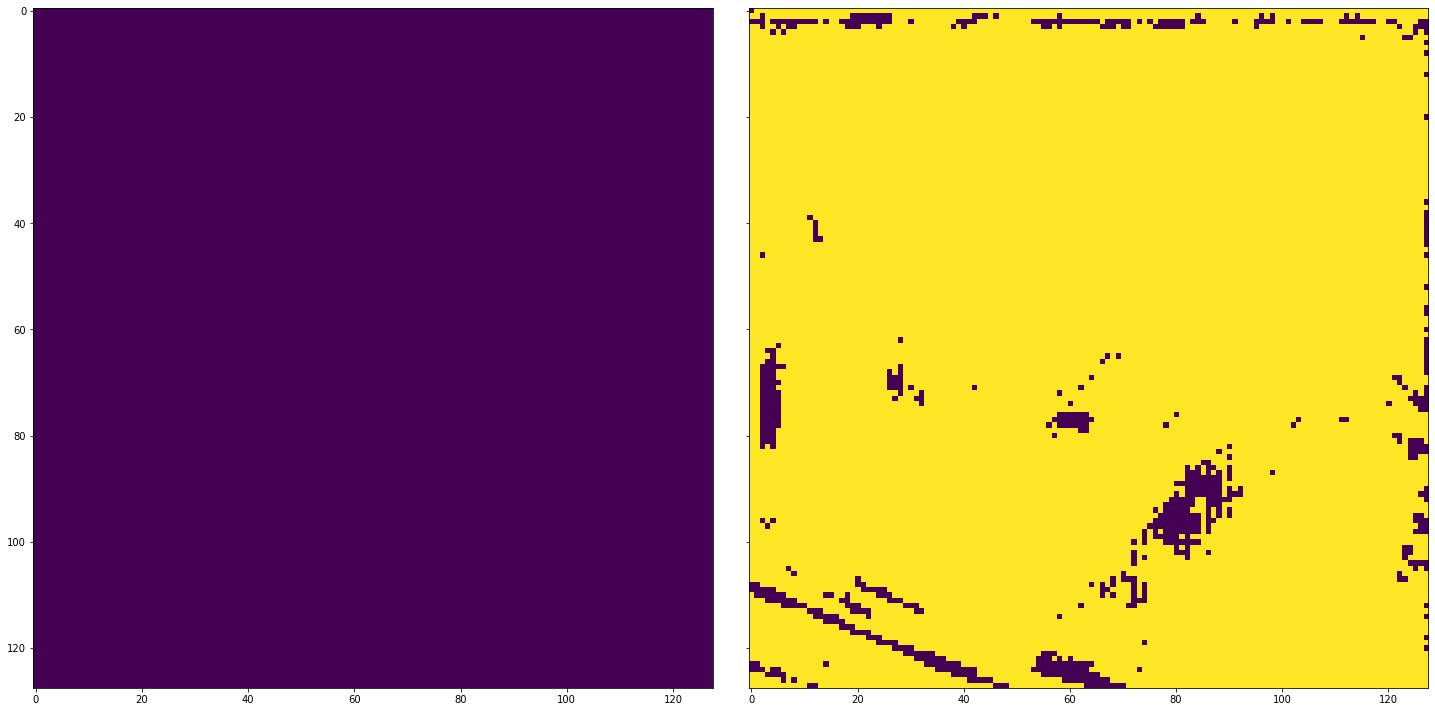

100%|██████████| 117/117 [00:13<00:00,  8.56it/s, loss=-8.86]


=> Saving checkpoint
Got 2061733/2277376 with accuracy 90.53
Dice score: 0.37449467182159424
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


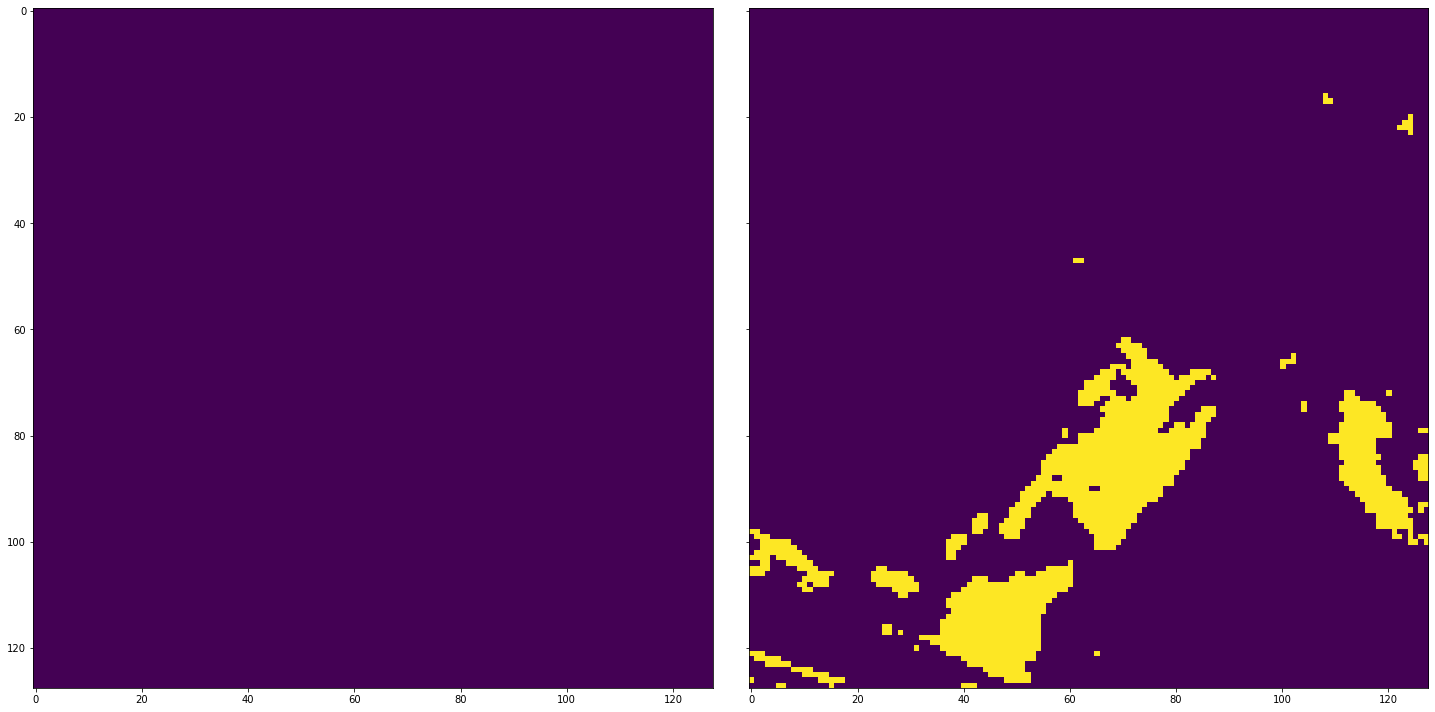

100%|██████████| 117/117 [00:13<00:00,  8.48it/s, loss=0.638]


=> Saving checkpoint
Got 1794828/2277376 with accuracy 78.81
Dice score: 0.30543753504753113
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


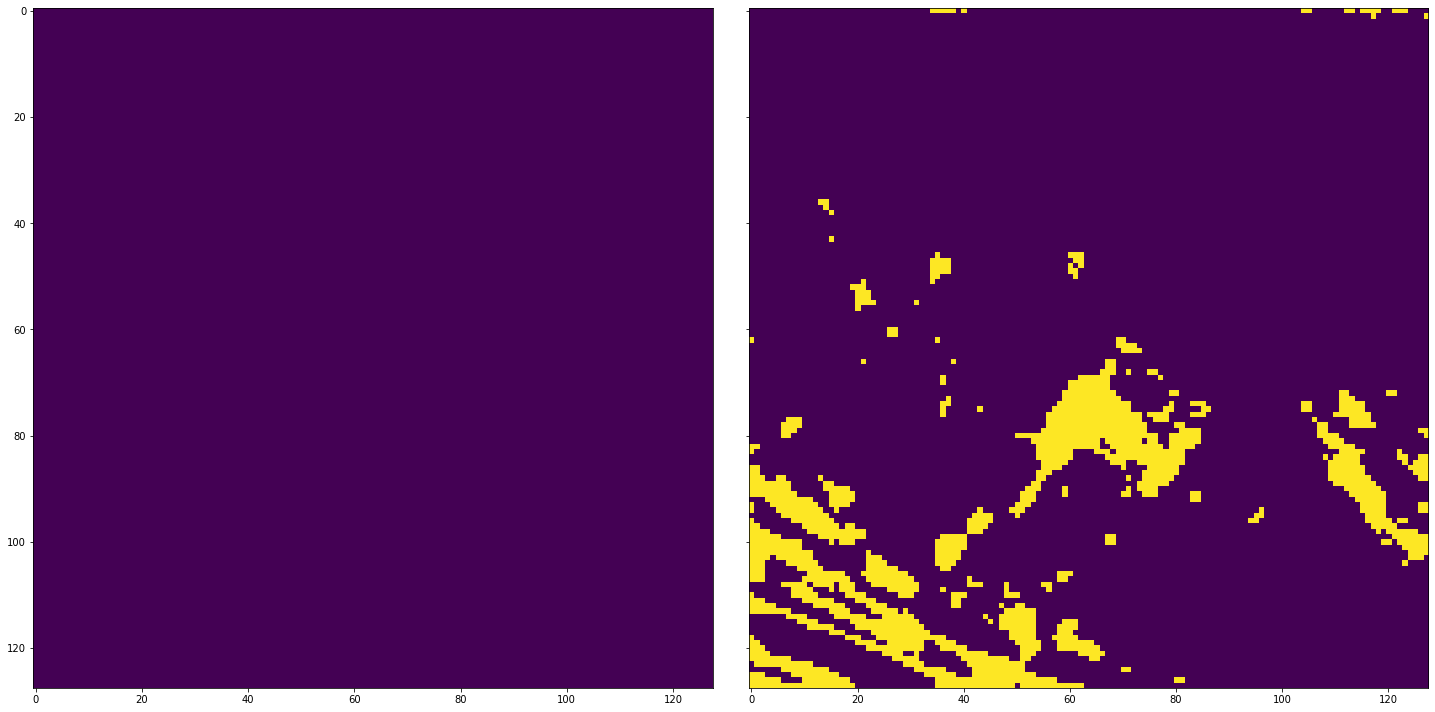

100%|██████████| 117/117 [00:13<00:00,  8.51it/s, loss=0.629]


=> Saving checkpoint
Got 1931784/2277376 with accuracy 84.82
Dice score: 0.3372156322002411
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


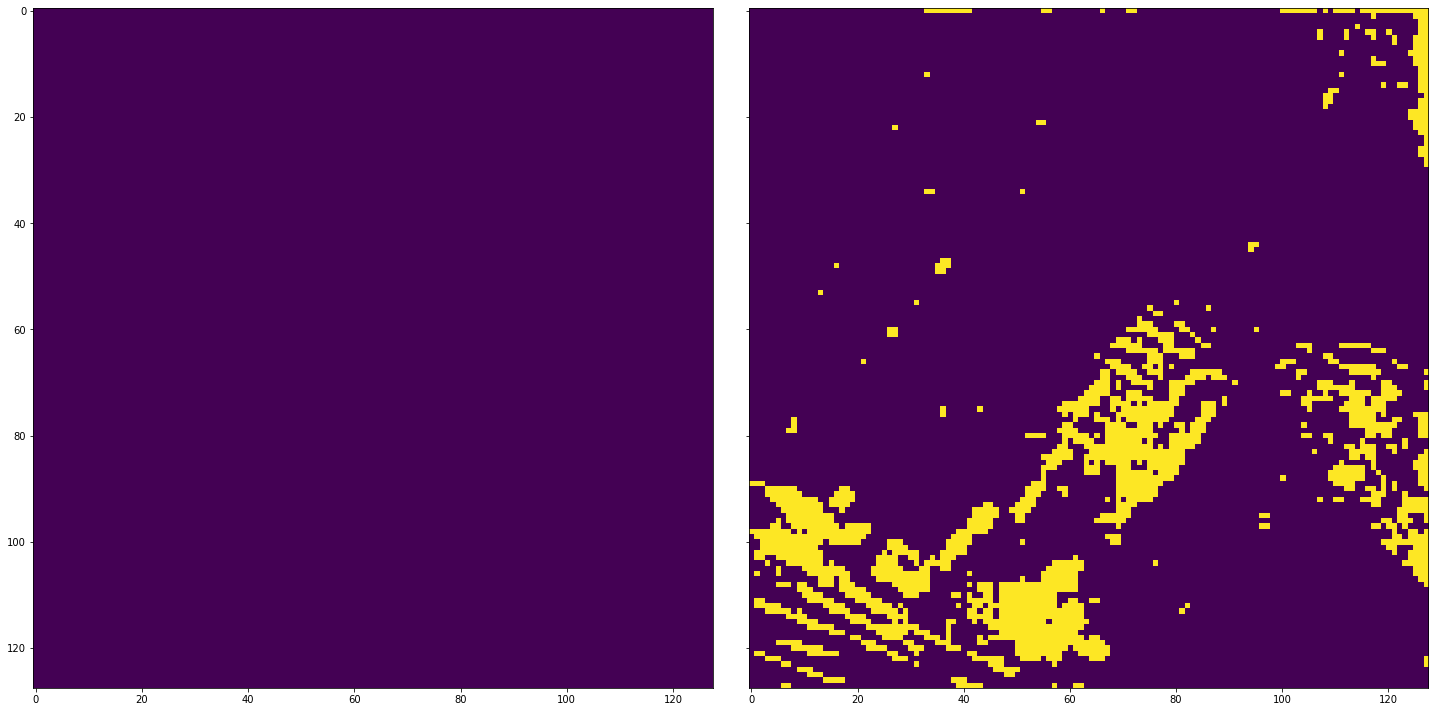

100%|██████████| 117/117 [00:13<00:00,  8.48it/s, loss=0.638]


=> Saving checkpoint
Got 1922037/2277376 with accuracy 84.40
Dice score: 0.34702038764953613
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


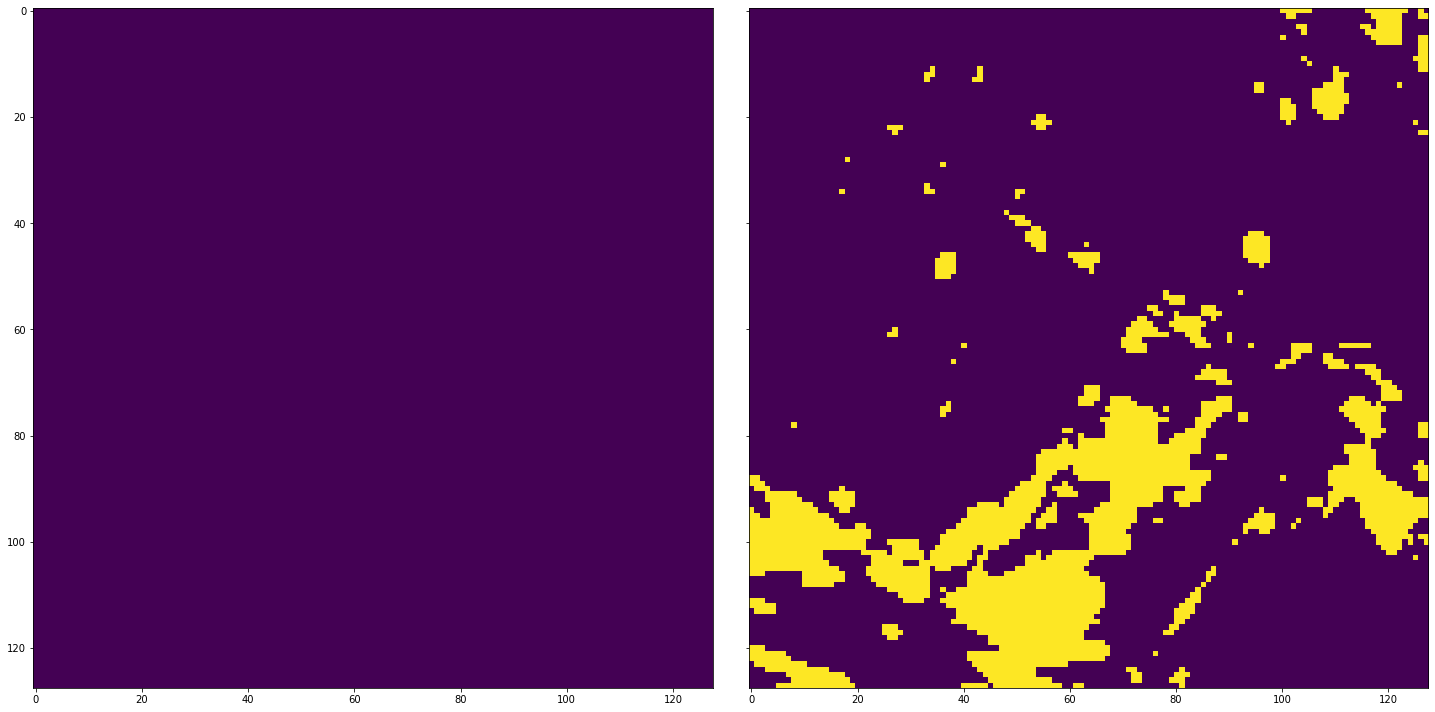

100%|██████████| 117/117 [00:13<00:00,  8.46it/s, loss=-16.3]


=> Saving checkpoint
Got 1626697/2277376 with accuracy 71.43
Dice score: 0.2954380512237549
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


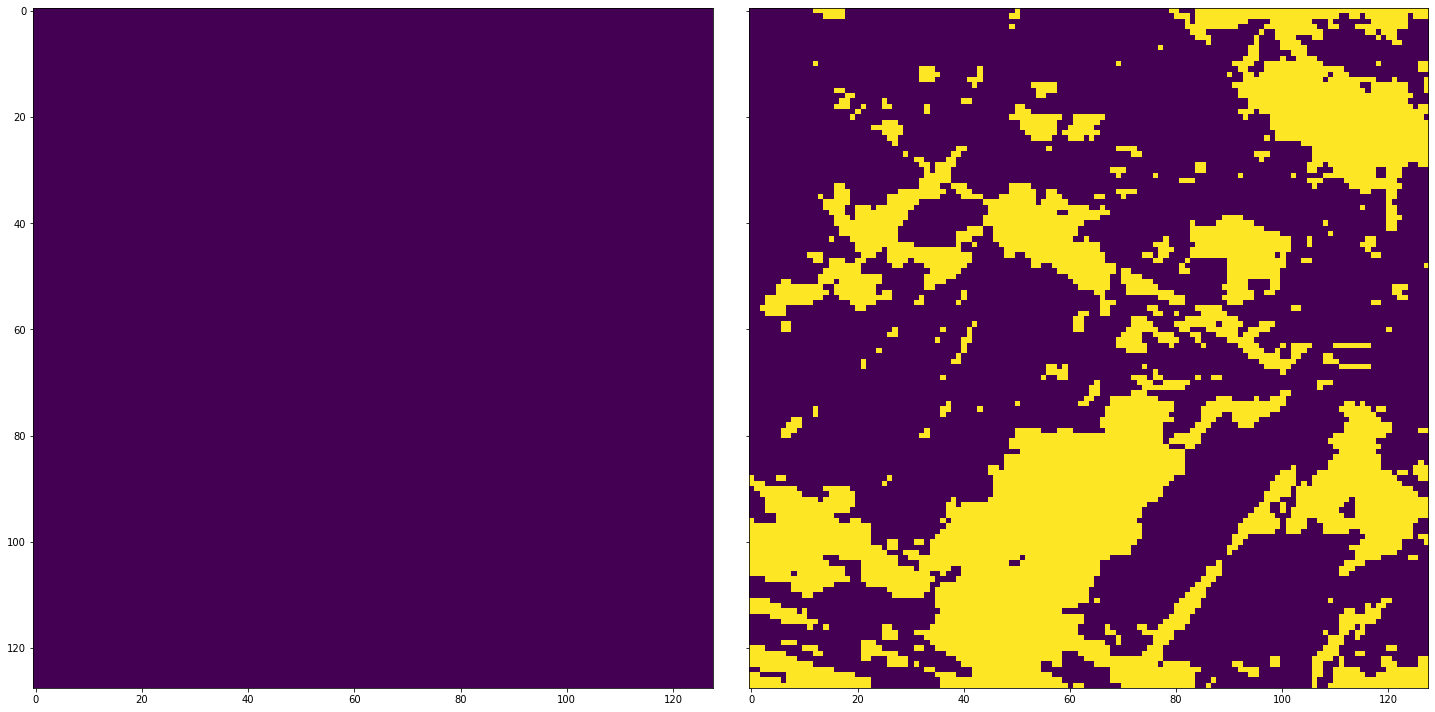

100%|██████████| 117/117 [00:13<00:00,  8.43it/s, loss=-10.4]


=> Saving checkpoint
Got 1781104/2277376 with accuracy 78.21
Dice score: 0.30599647760391235
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


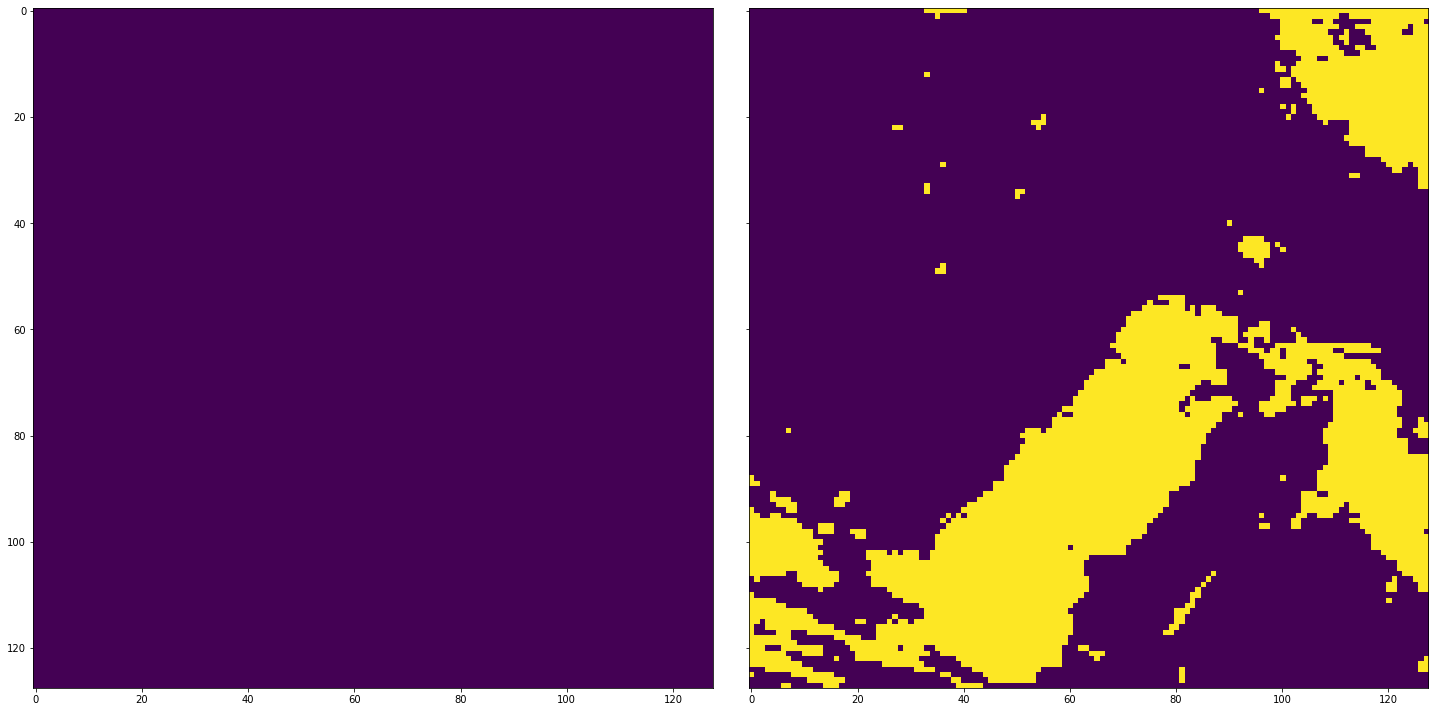

100%|██████████| 117/117 [00:13<00:00,  8.42it/s, loss=0.533]


=> Saving checkpoint
Got 2179834/2277376 with accuracy 95.72
Dice score: 0.4167736768722534
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


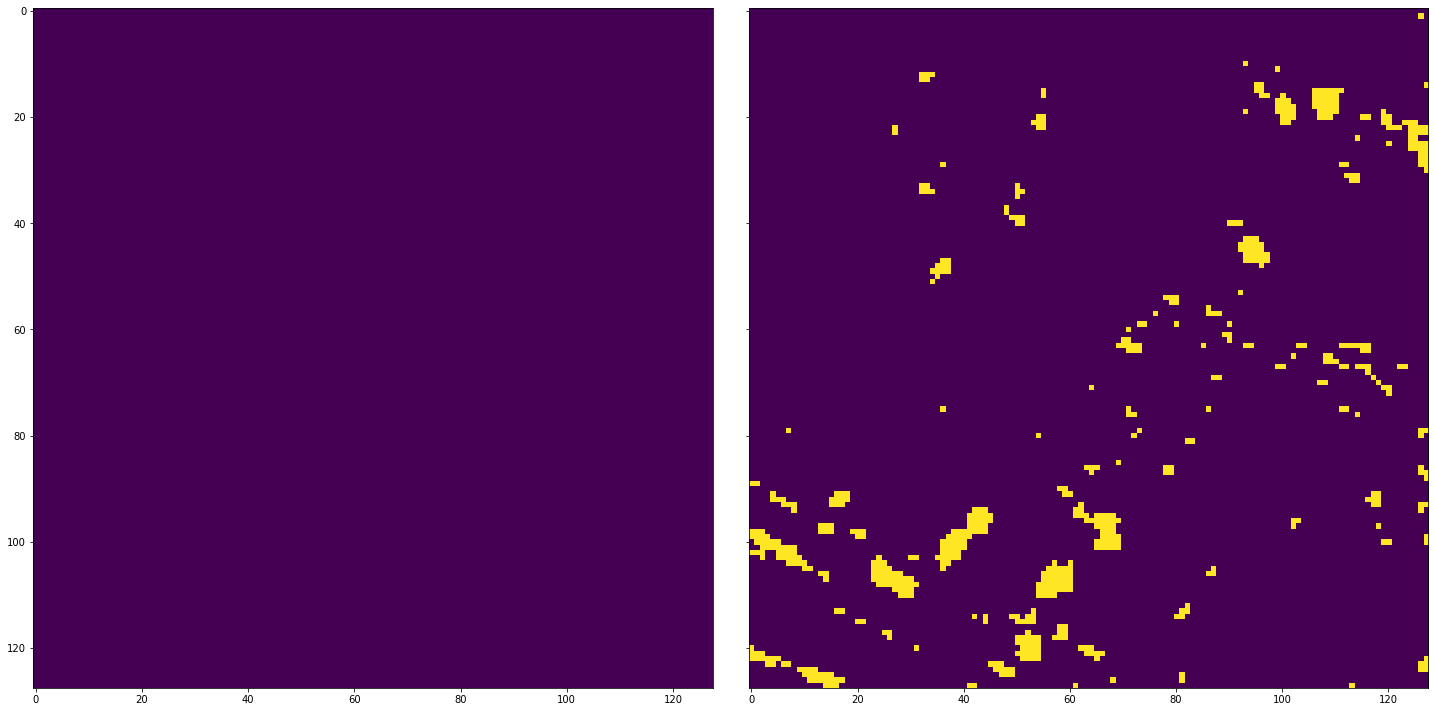

100%|██████████| 117/117 [00:13<00:00,  8.43it/s, loss=0.632]


=> Saving checkpoint
Got 1977223/2277376 with accuracy 86.82
Dice score: 0.3726694881916046
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


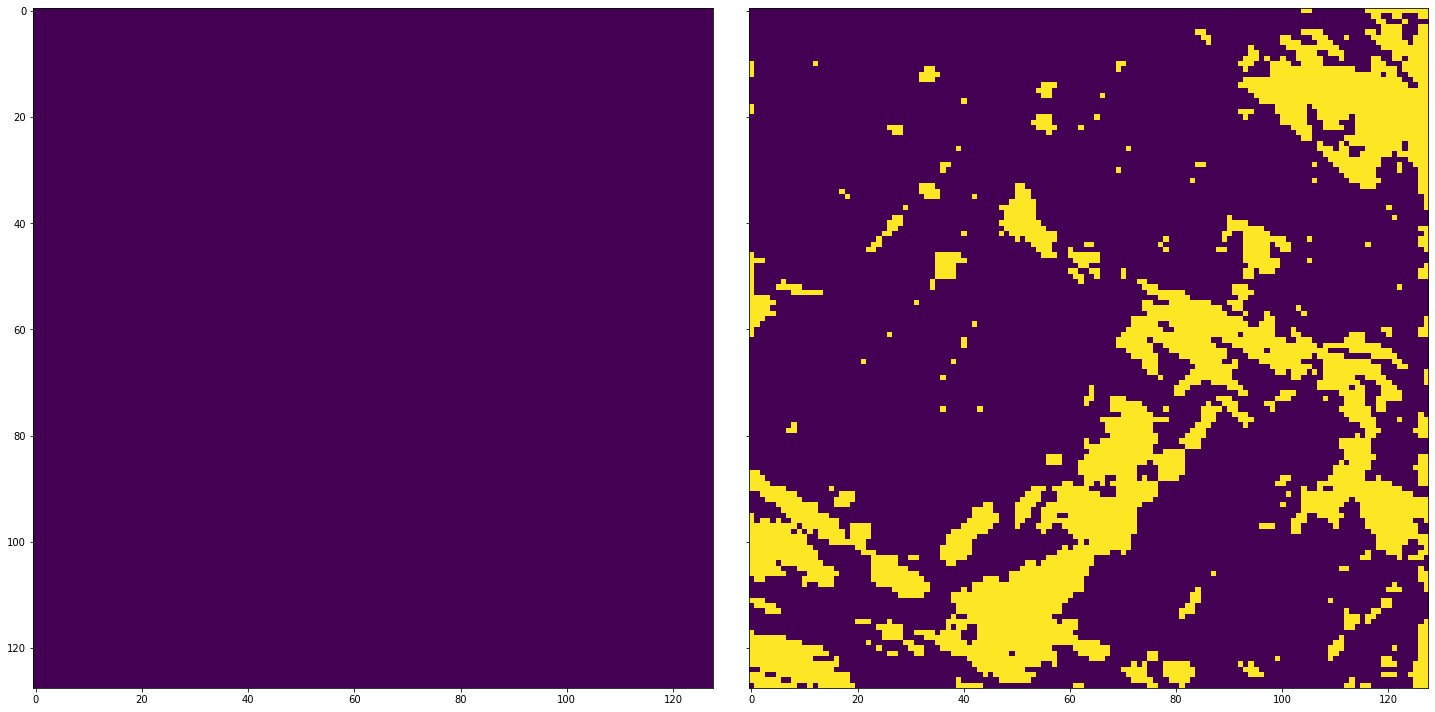

100%|██████████| 117/117 [00:13<00:00,  8.43it/s, loss=0.487]


=> Saving checkpoint
Got 2033876/2277376 with accuracy 89.31
Dice score: 0.38803333044052124
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


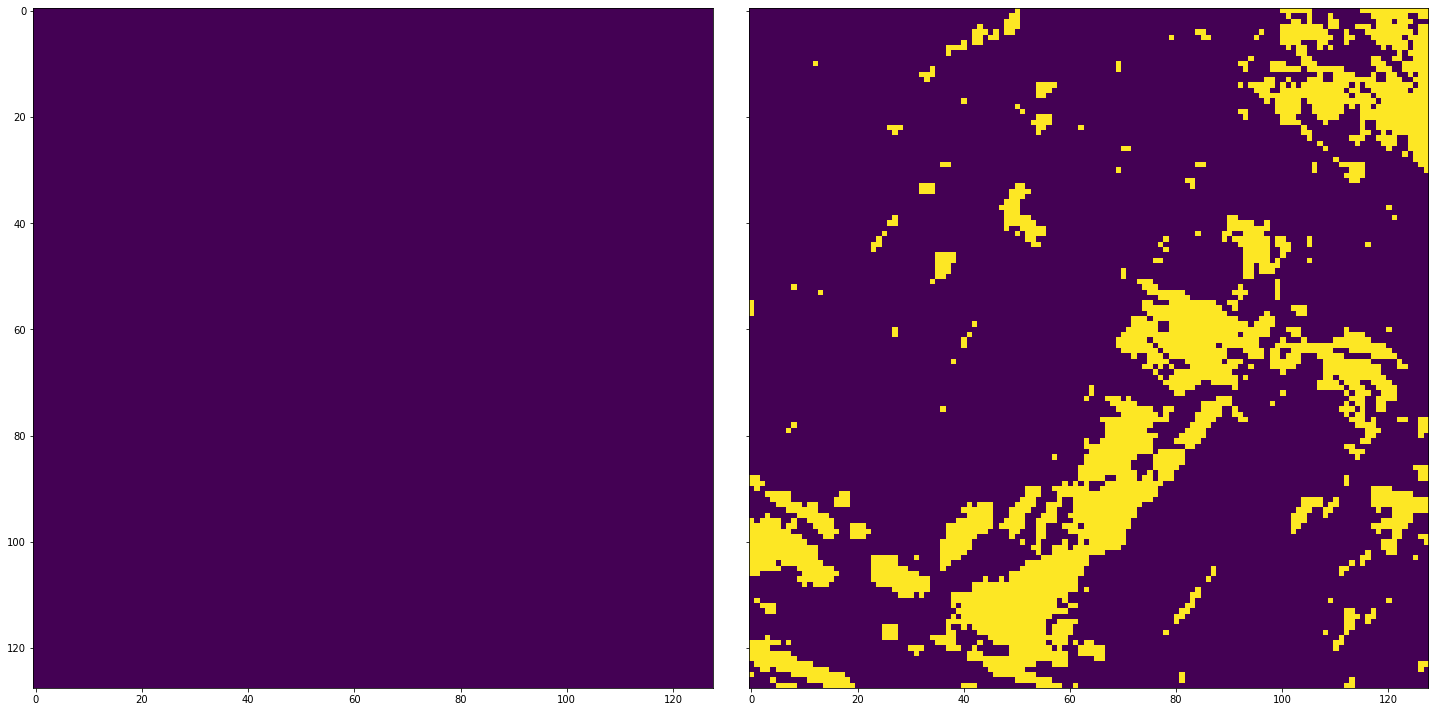

100%|██████████| 117/117 [00:13<00:00,  8.43it/s, loss=0.642]


=> Saving checkpoint
Got 1803070/2277376 with accuracy 79.17
Dice score: 0.35024115443229675
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


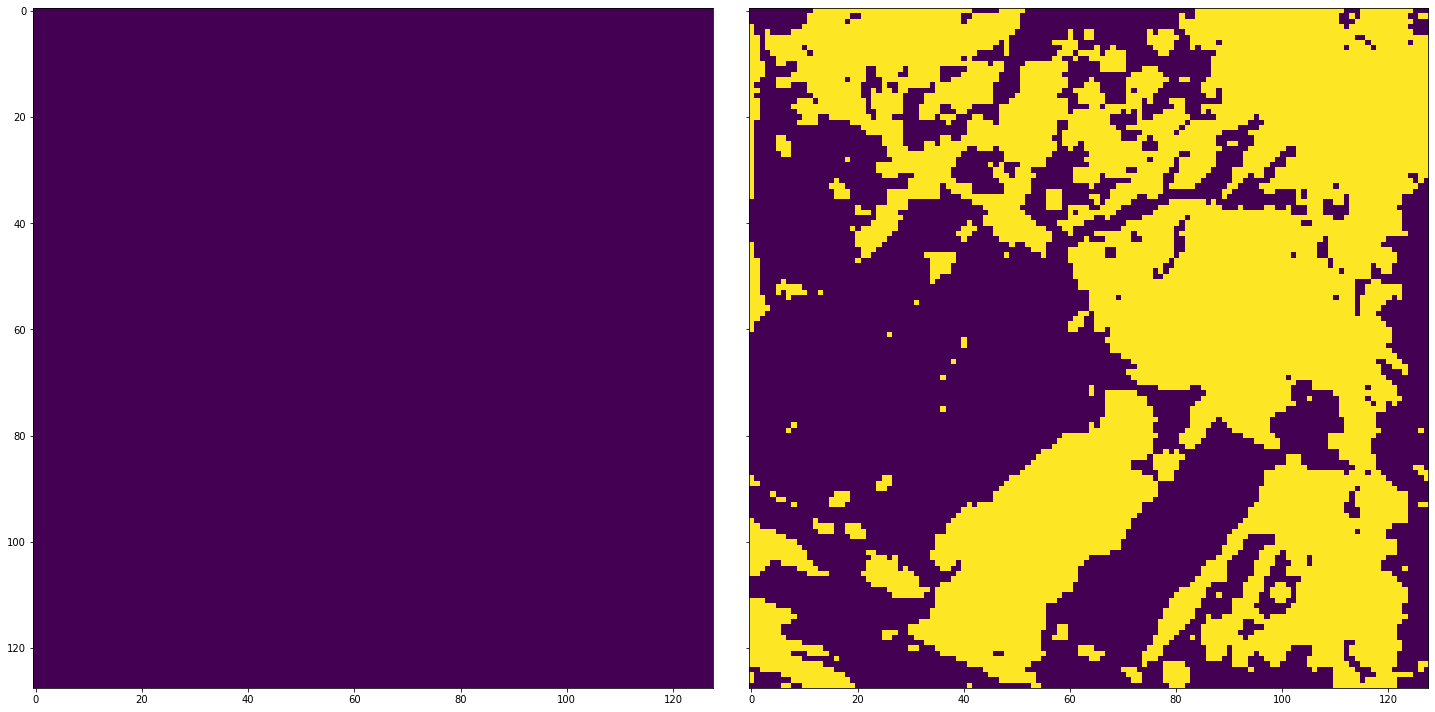

100%|██████████| 117/117 [00:13<00:00,  8.43it/s, loss=0.479]


=> Saving checkpoint
Got 1689376/2277376 with accuracy 74.18
Dice score: 0.3084818720817566
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


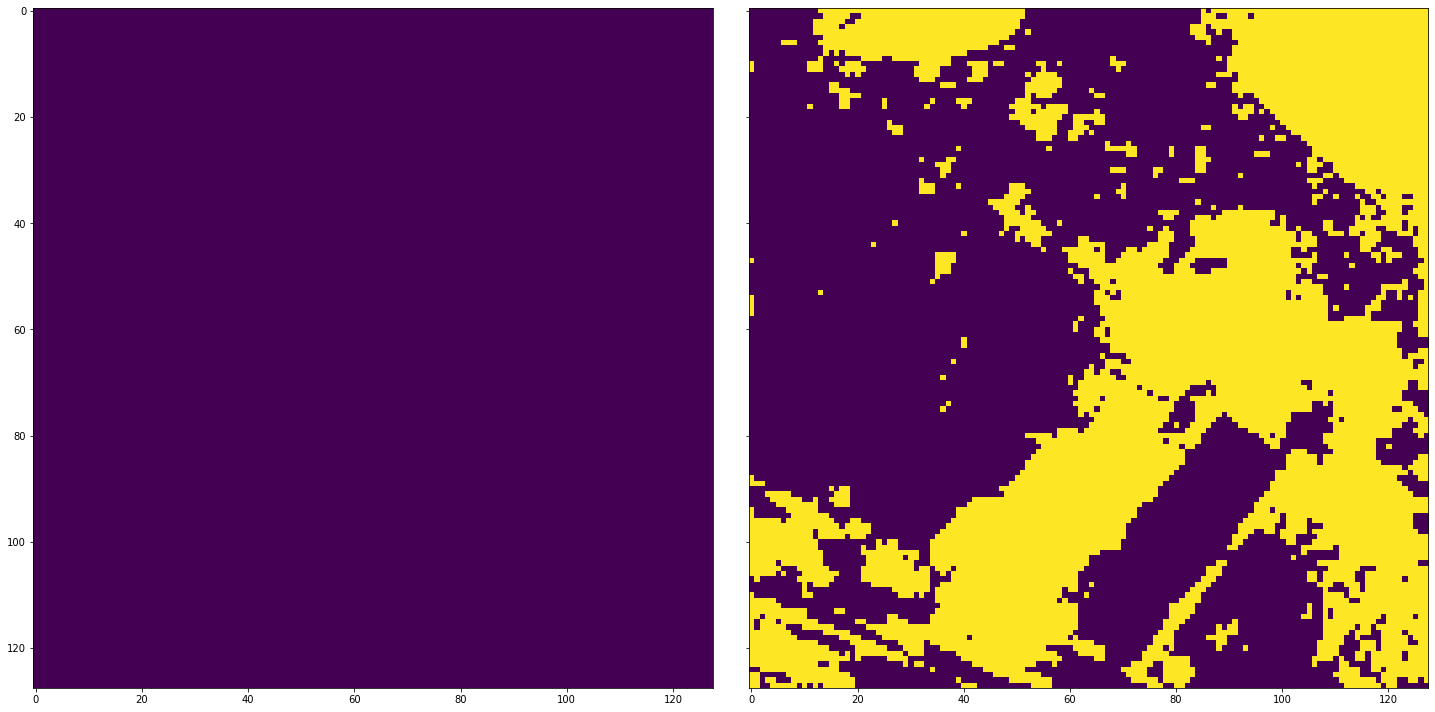

100%|██████████| 117/117 [00:13<00:00,  8.41it/s, loss=0.4]


=> Saving checkpoint
Got 1958924/2277376 with accuracy 86.02
Dice score: 0.34658172726631165
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


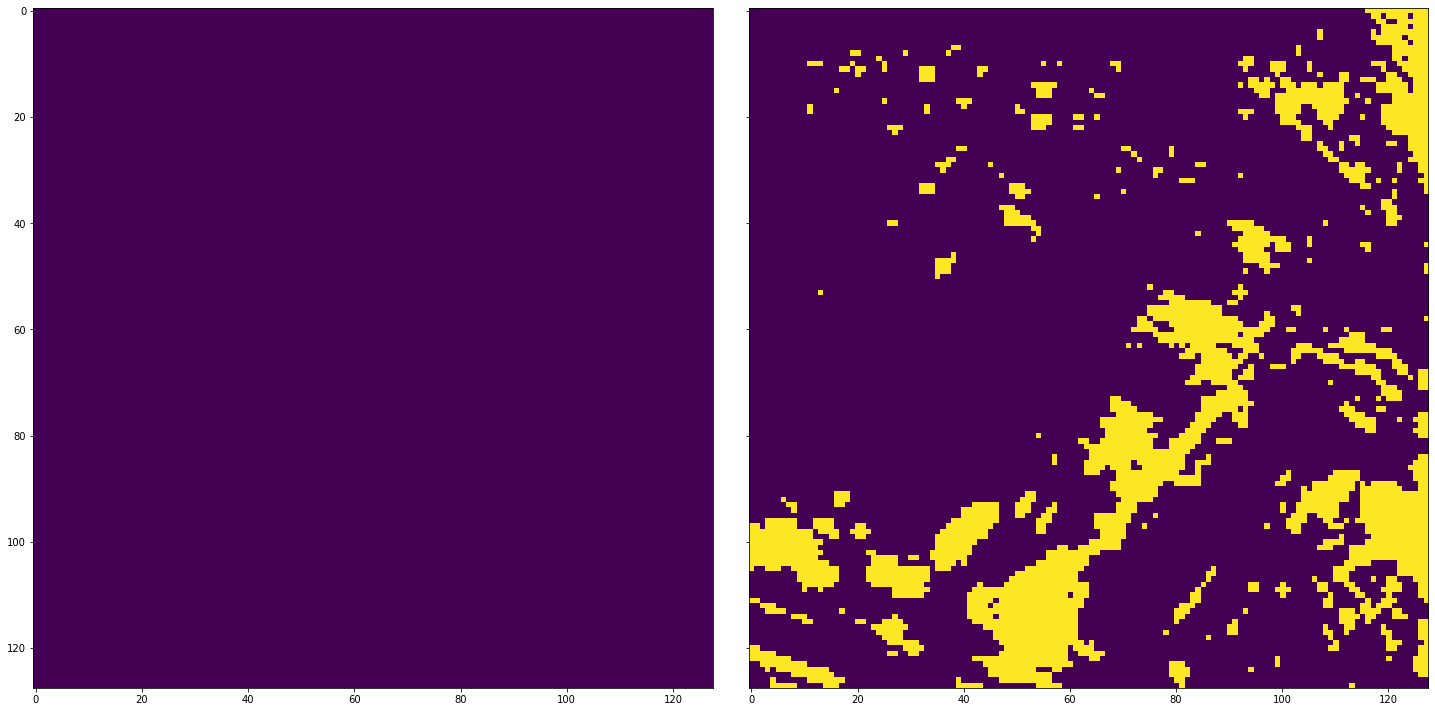

100%|██████████| 117/117 [00:13<00:00,  8.39it/s, loss=-.141]


=> Saving checkpoint
Got 1869392/2277376 with accuracy 82.09
Dice score: 0.32360324263572693
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


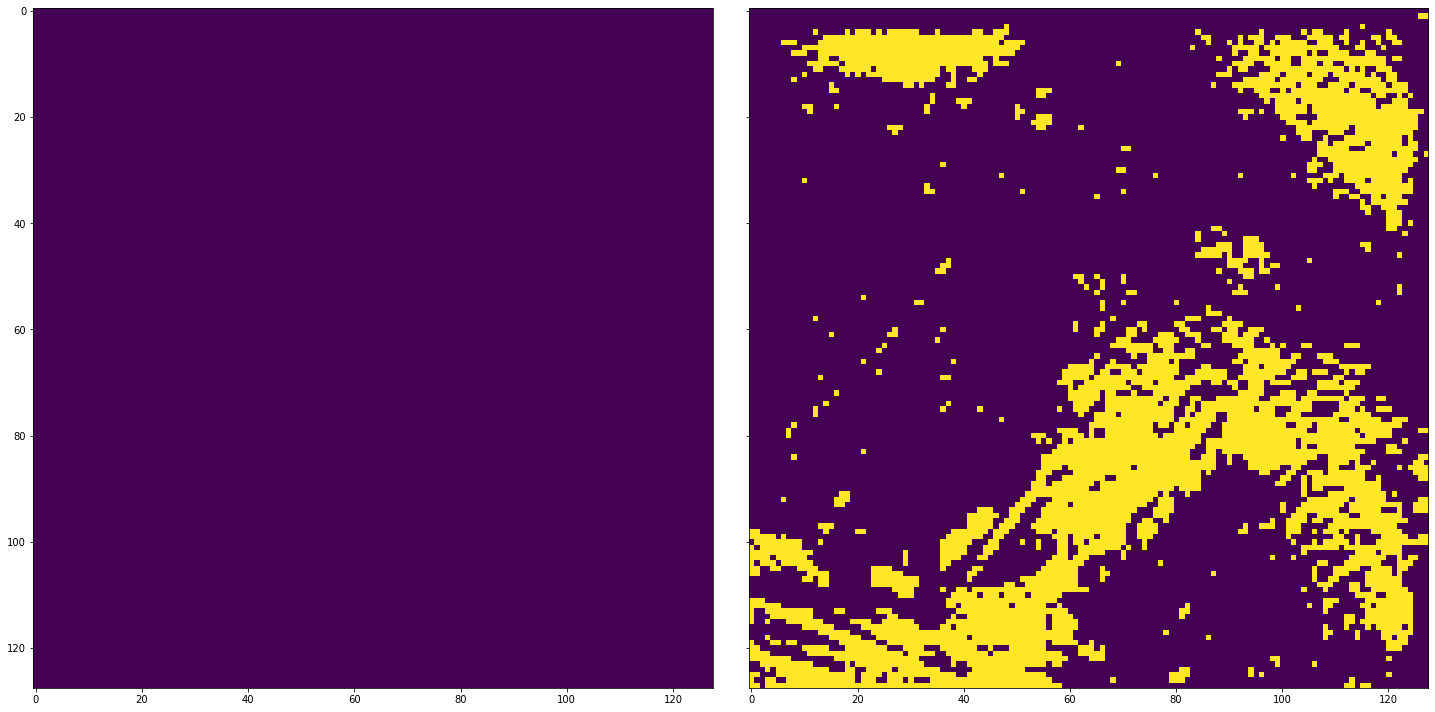

100%|██████████| 117/117 [00:13<00:00,  8.42it/s, loss=-9.54]


=> Saving checkpoint
Got 1914641/2277376 with accuracy 84.07
Dice score: 0.3470534384250641
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


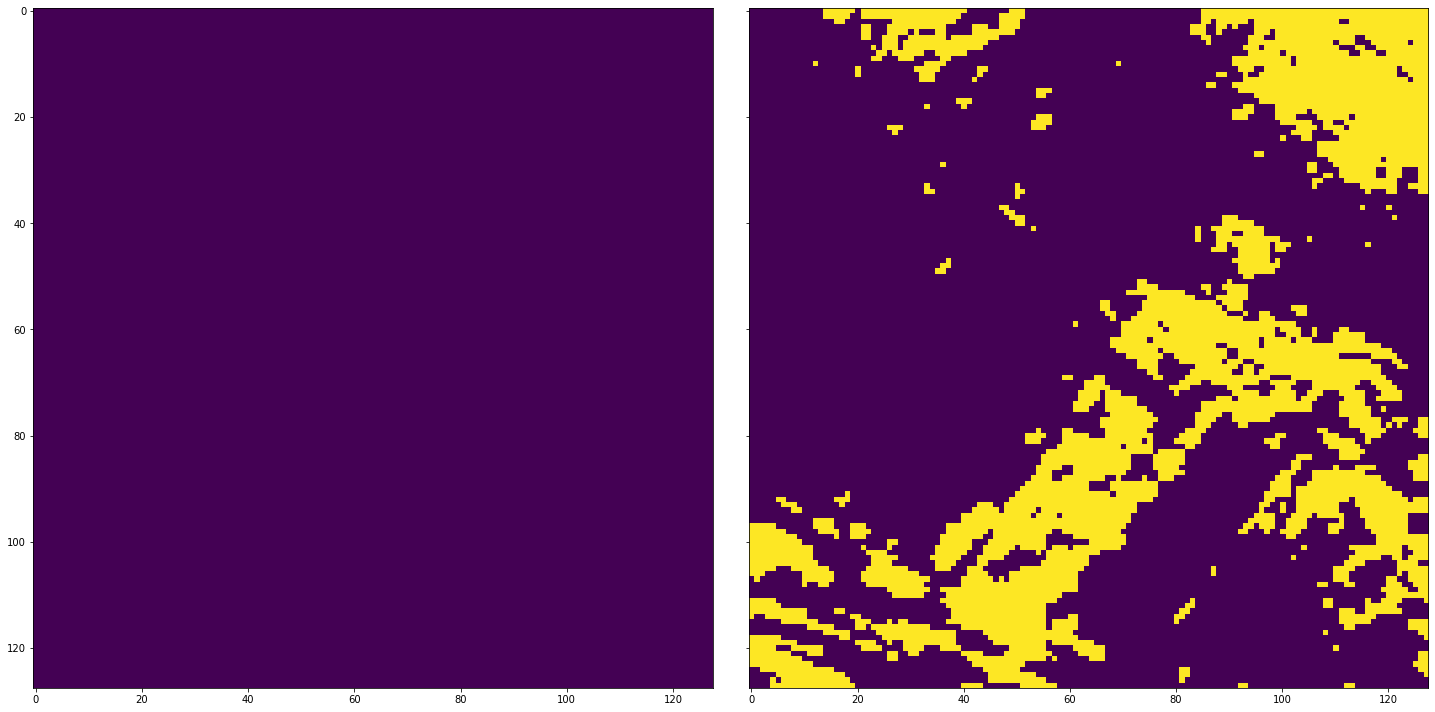

100%|██████████| 117/117 [00:14<00:00,  8.34it/s, loss=0.509]


=> Saving checkpoint
Got 2108515/2277376 with accuracy 92.59
Dice score: 0.40731680393218994
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


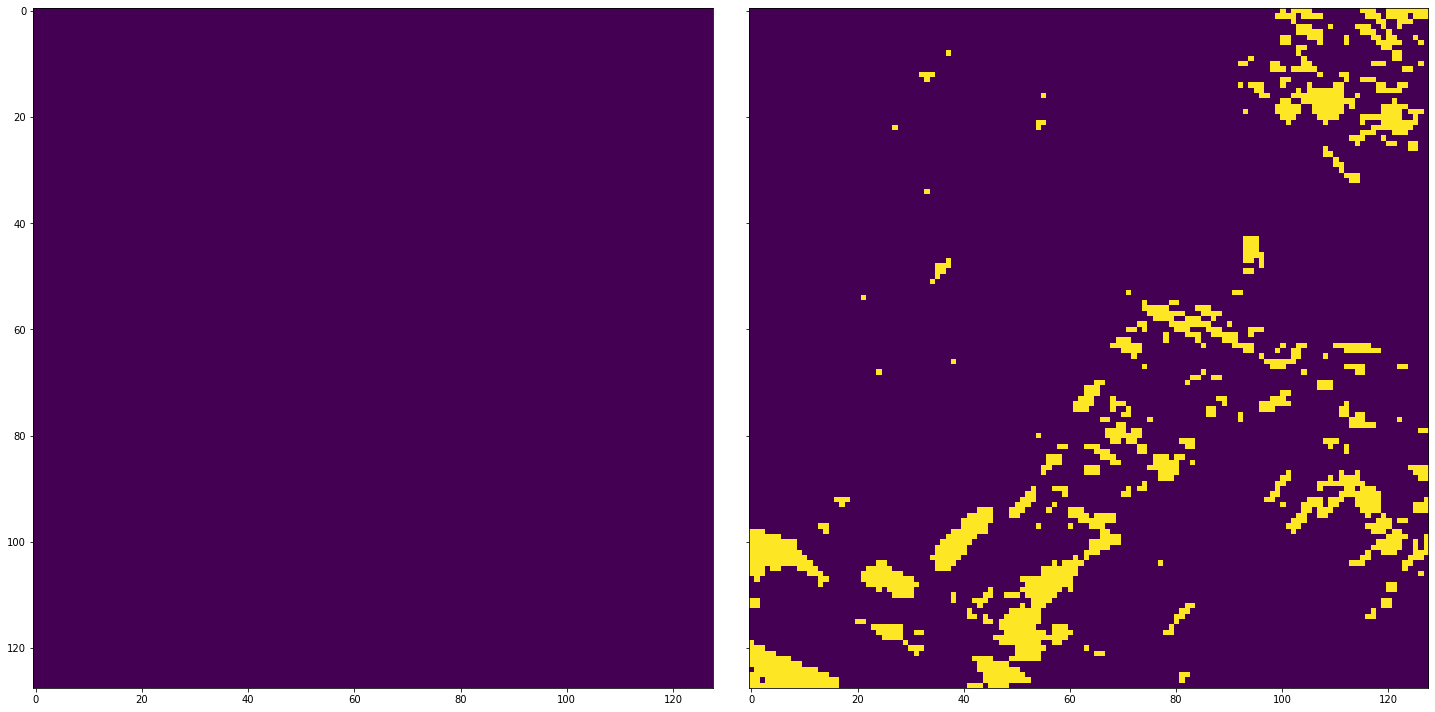

100%|██████████| 117/117 [00:13<00:00,  8.37it/s, loss=0.493]


=> Saving checkpoint
Got 1913851/2277376 with accuracy 84.04
Dice score: 0.33685651421546936
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


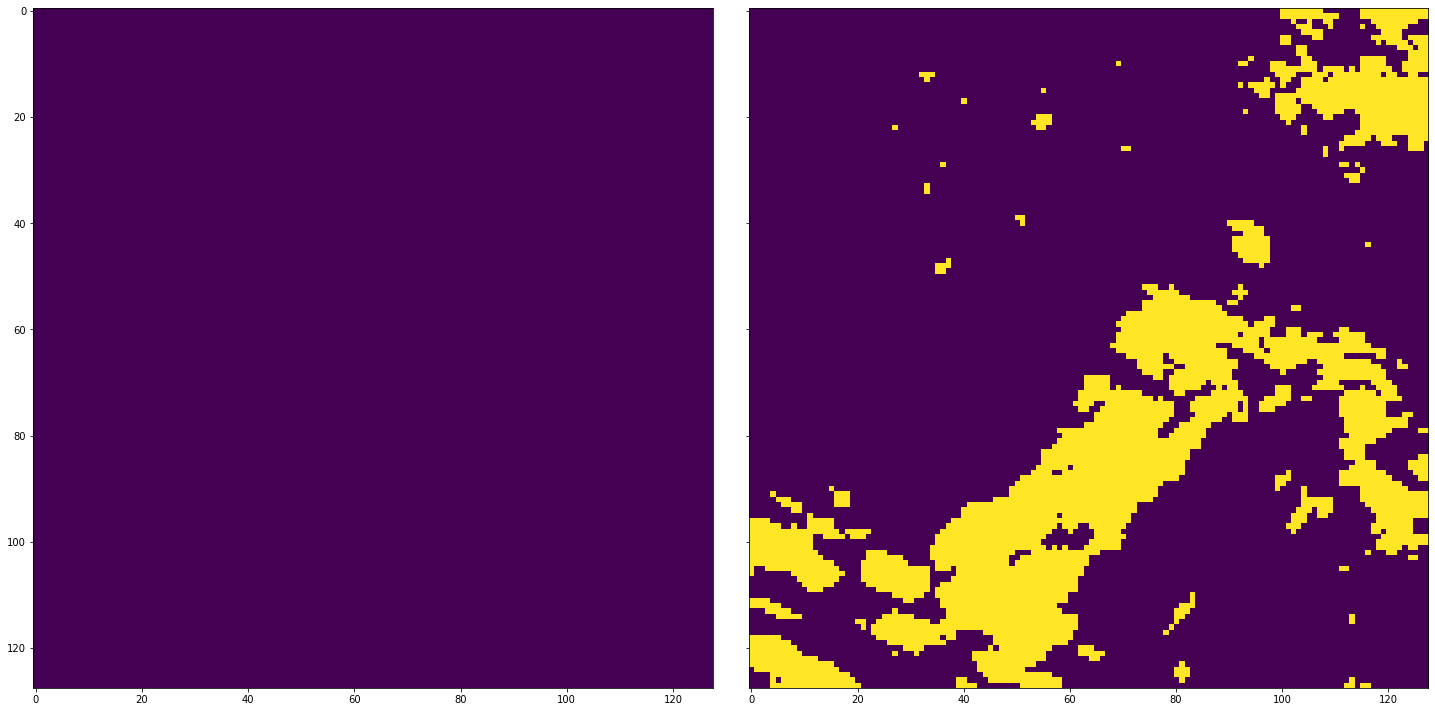

100%|██████████| 117/117 [00:13<00:00,  8.38it/s, loss=0.452]


=> Saving checkpoint
Got 2217462/2277376 with accuracy 97.37
Dice score: 0.451423704624176
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


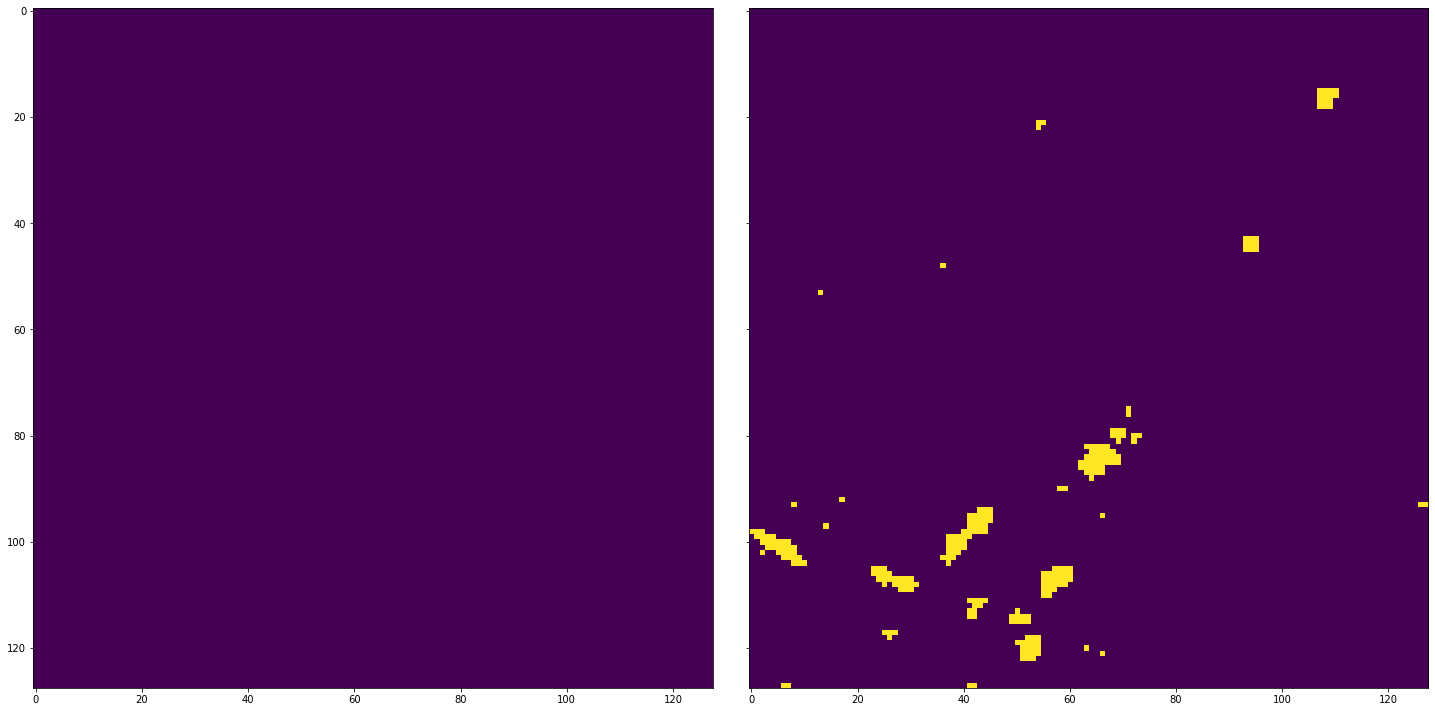

100%|██████████| 117/117 [00:14<00:00,  8.32it/s, loss=0.567]


=> Saving checkpoint
Got 2156703/2277376 with accuracy 94.70
Dice score: 0.4290280342102051
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


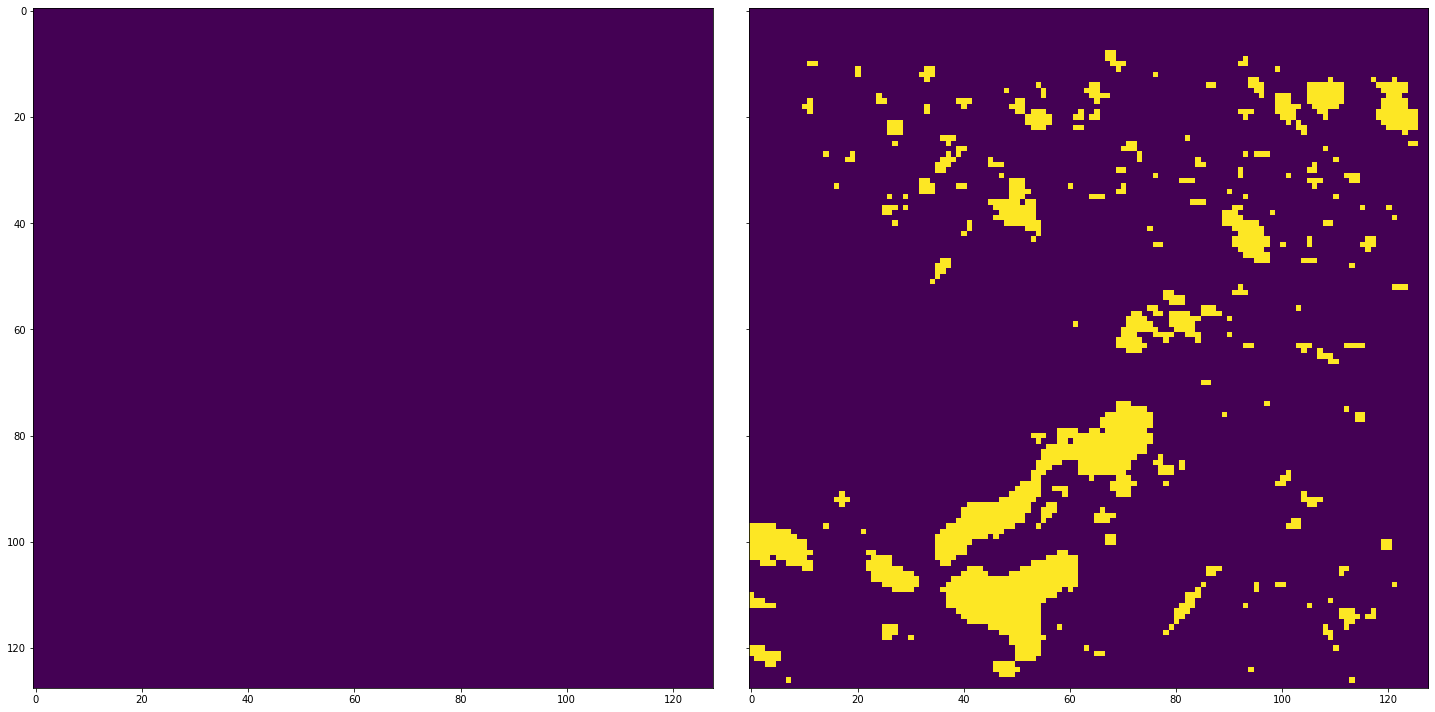

100%|██████████| 117/117 [00:13<00:00,  8.38it/s, loss=-3.83]


=> Saving checkpoint
Got 1798726/2277376 with accuracy 78.98
Dice score: 0.3033912181854248
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


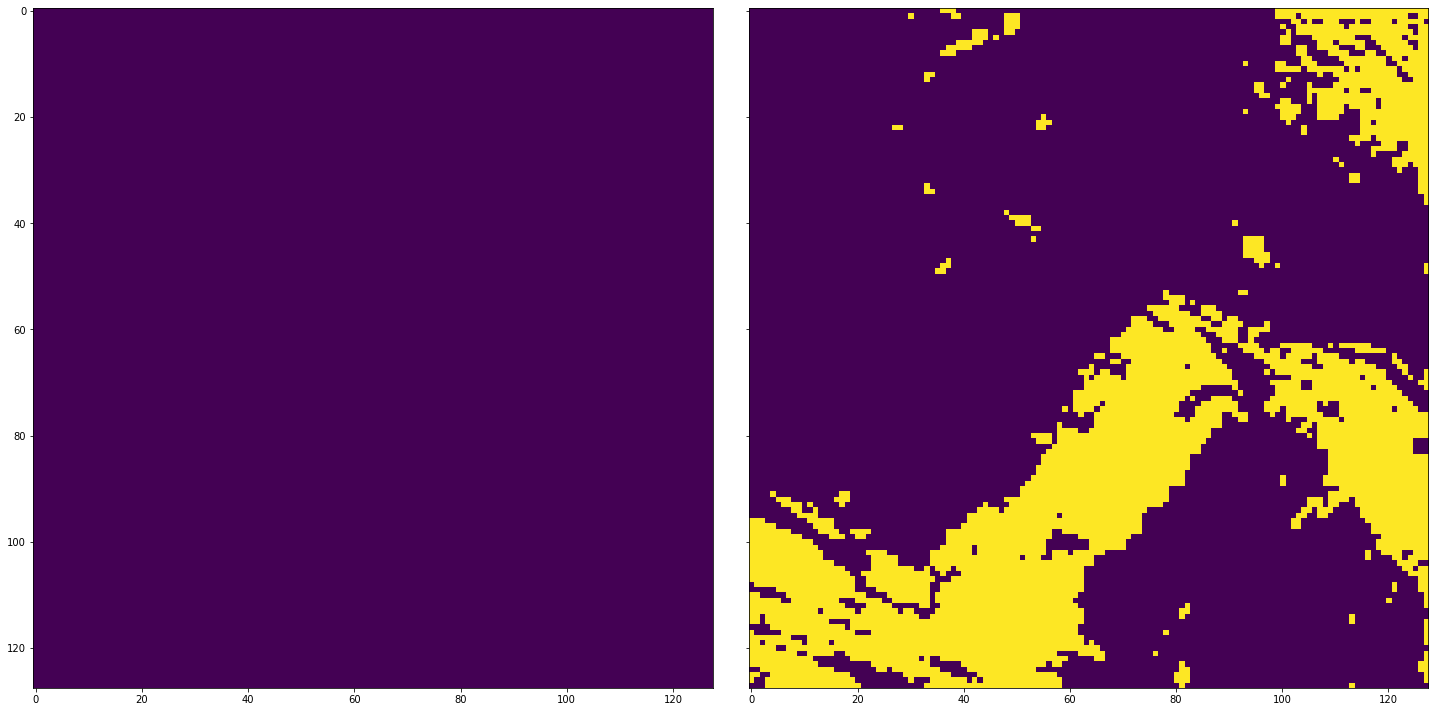

100%|██████████| 117/117 [00:14<00:00,  8.35it/s, loss=-20.9]


=> Saving checkpoint
Got 2165252/2277376 with accuracy 95.08
Dice score: 0.4477032423019409
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


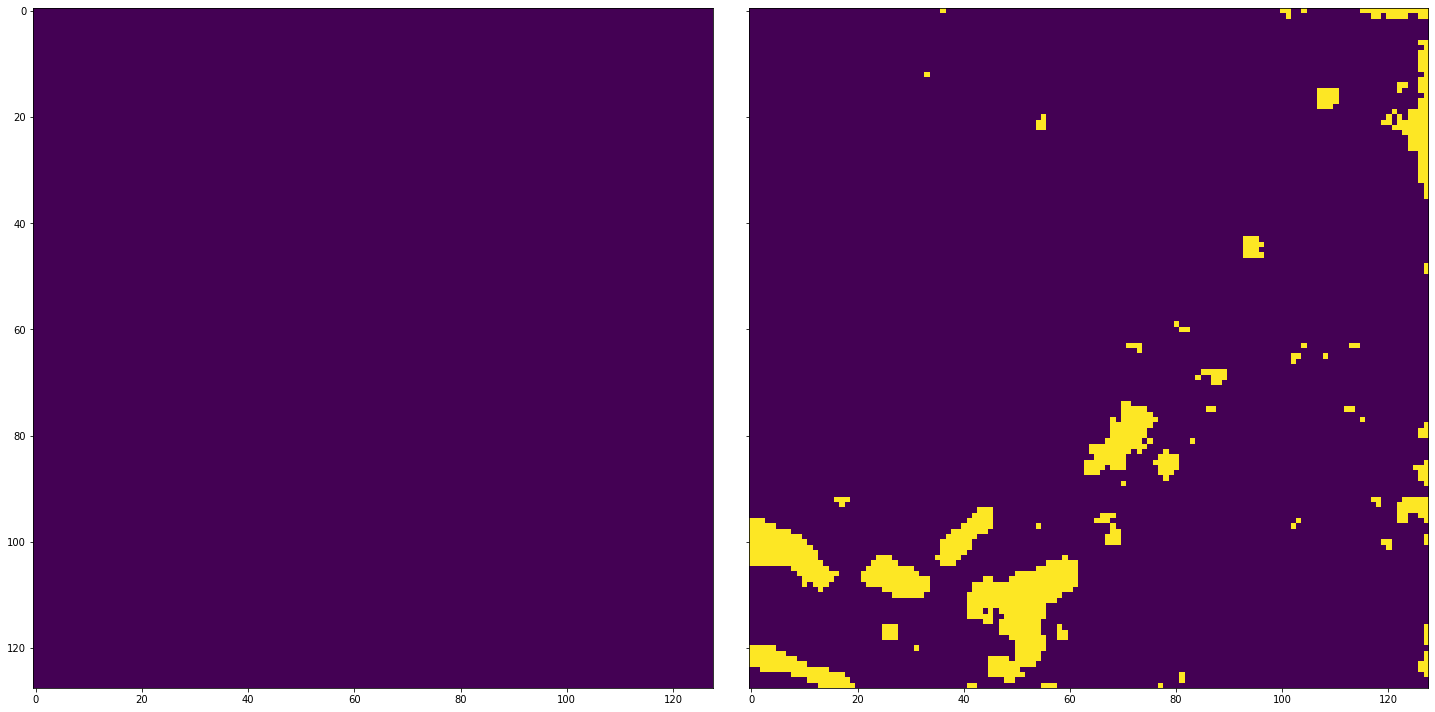

100%|██████████| 117/117 [00:14<00:00,  8.31it/s, loss=-22.7]


=> Saving checkpoint
Got 2176225/2277376 with accuracy 95.56
Dice score: 0.44317126274108887
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


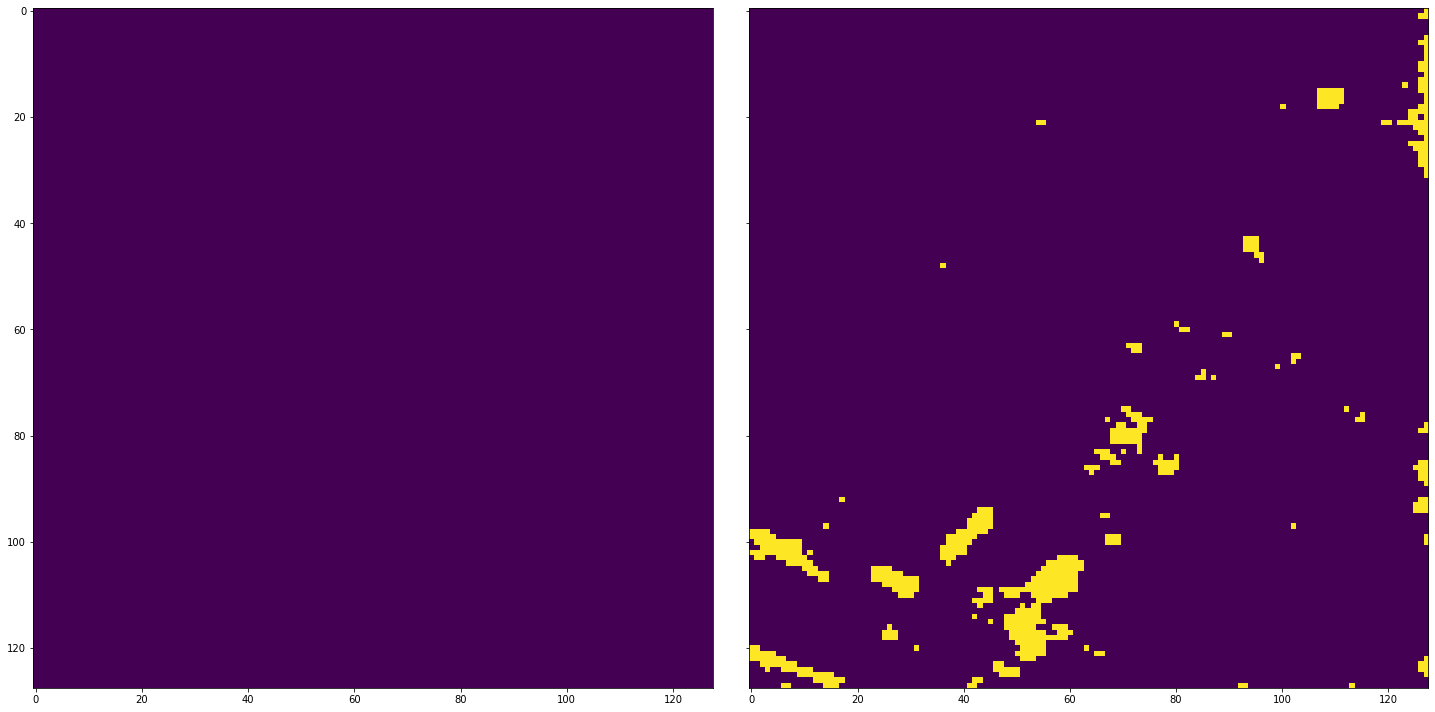

100%|██████████| 117/117 [00:14<00:00,  8.35it/s, loss=-30.8]


=> Saving checkpoint
Got 2167125/2277376 with accuracy 95.16
Dice score: 0.44836074113845825
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


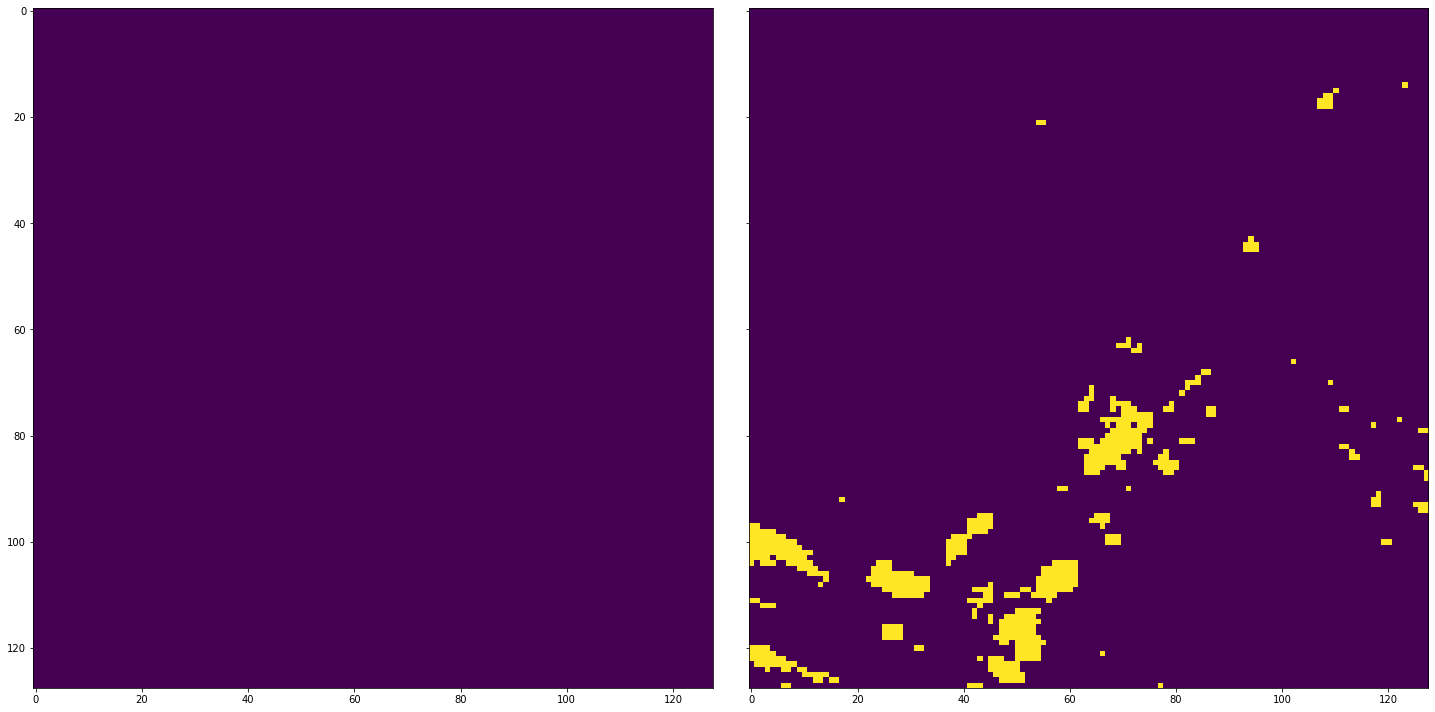

100%|██████████| 117/117 [00:13<00:00,  8.37it/s, loss=1.01]


=> Saving checkpoint
Got 1372047/2277376 with accuracy 60.25
Dice score: 0.27227336168289185
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


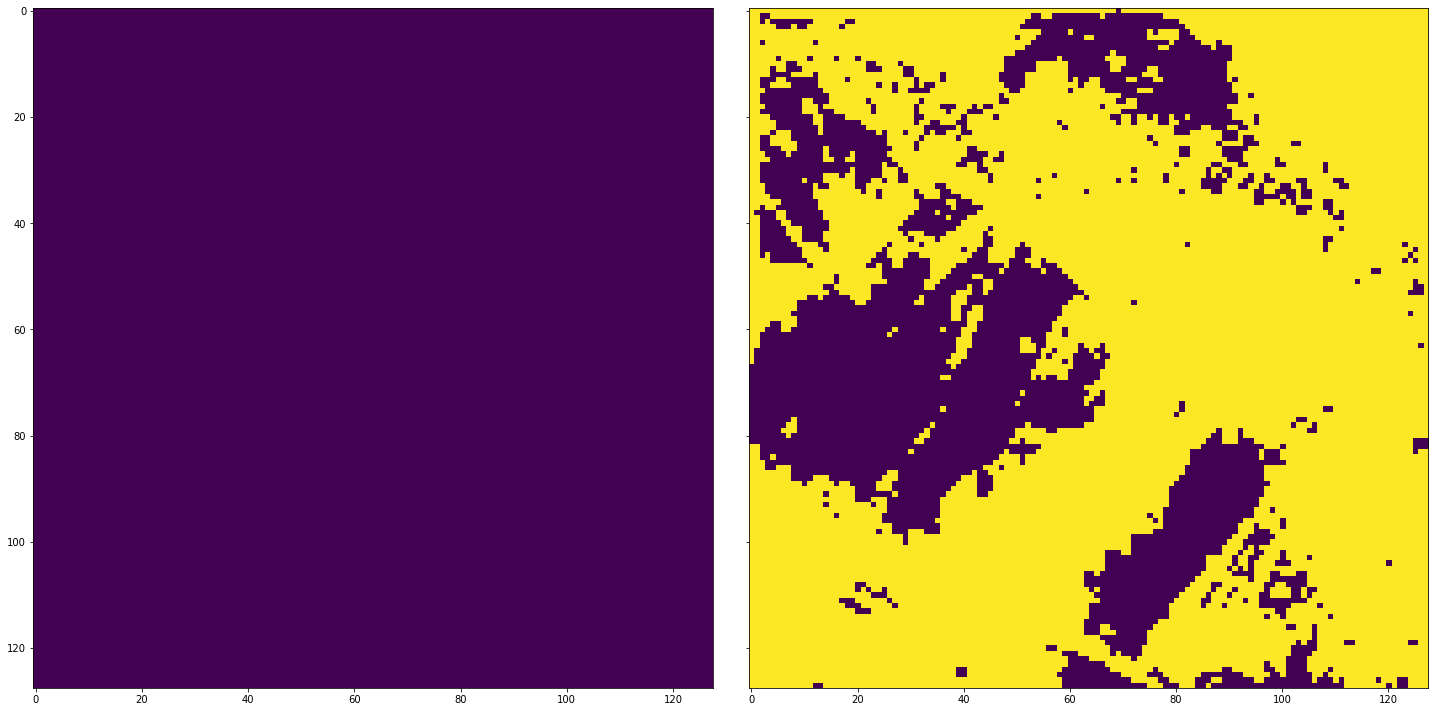

100%|██████████| 117/117 [00:13<00:00,  8.37it/s, loss=0.52]


=> Saving checkpoint
Got 1942454/2277376 with accuracy 85.29
Dice score: 0.36957114934921265
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


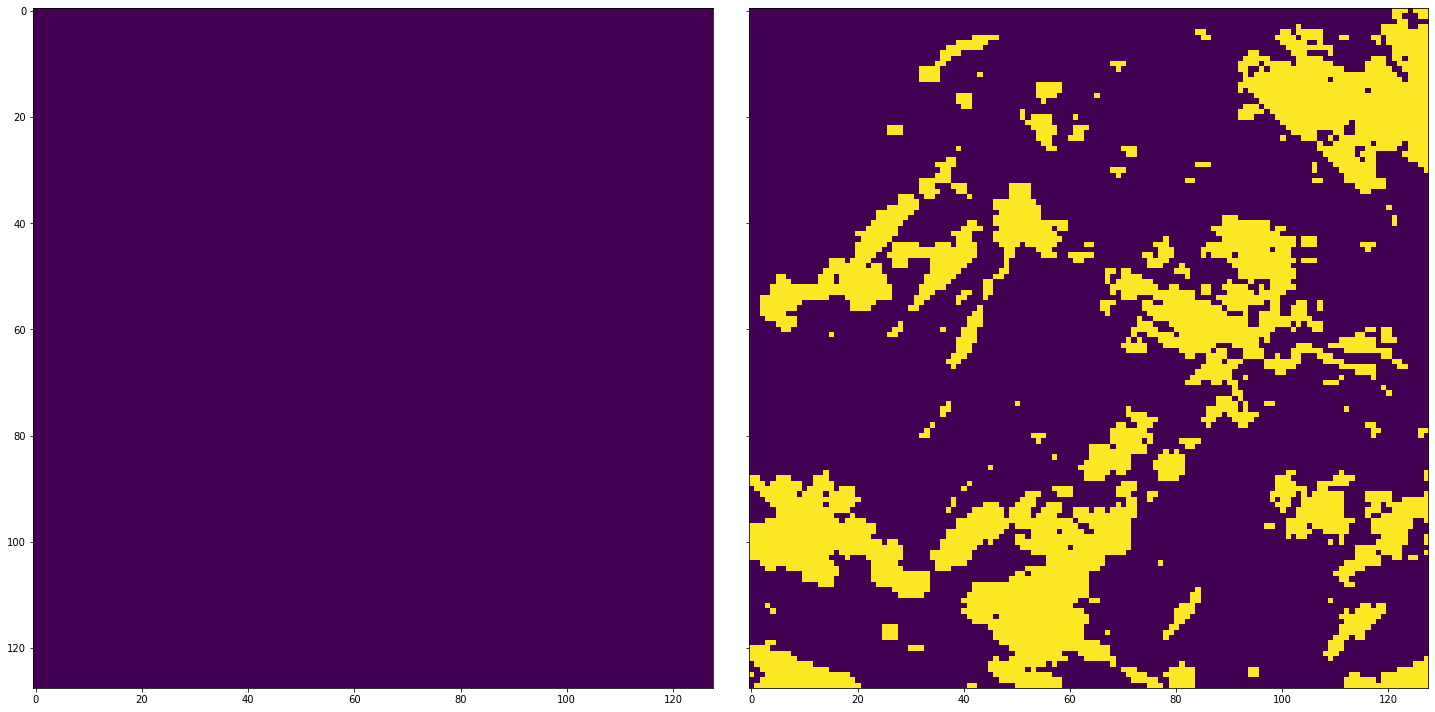

100%|██████████| 117/117 [00:14<00:00,  8.31it/s, loss=0.688]


=> Saving checkpoint
Got 2089730/2277376 with accuracy 91.76
Dice score: 0.4008227288722992
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


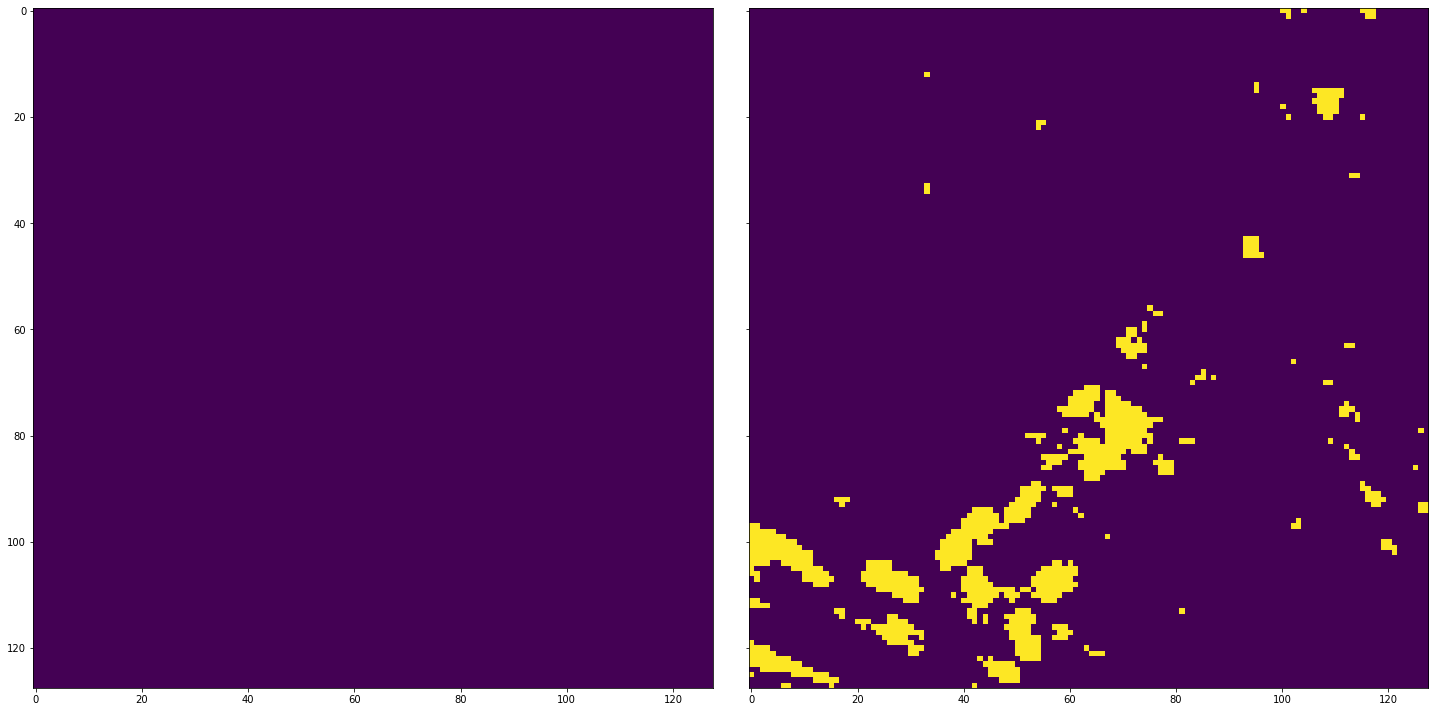

100%|██████████| 117/117 [00:13<00:00,  8.39it/s, loss=-10.7]


=> Saving checkpoint
Got 1920219/2277376 with accuracy 84.32
Dice score: 0.33277246356010437
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


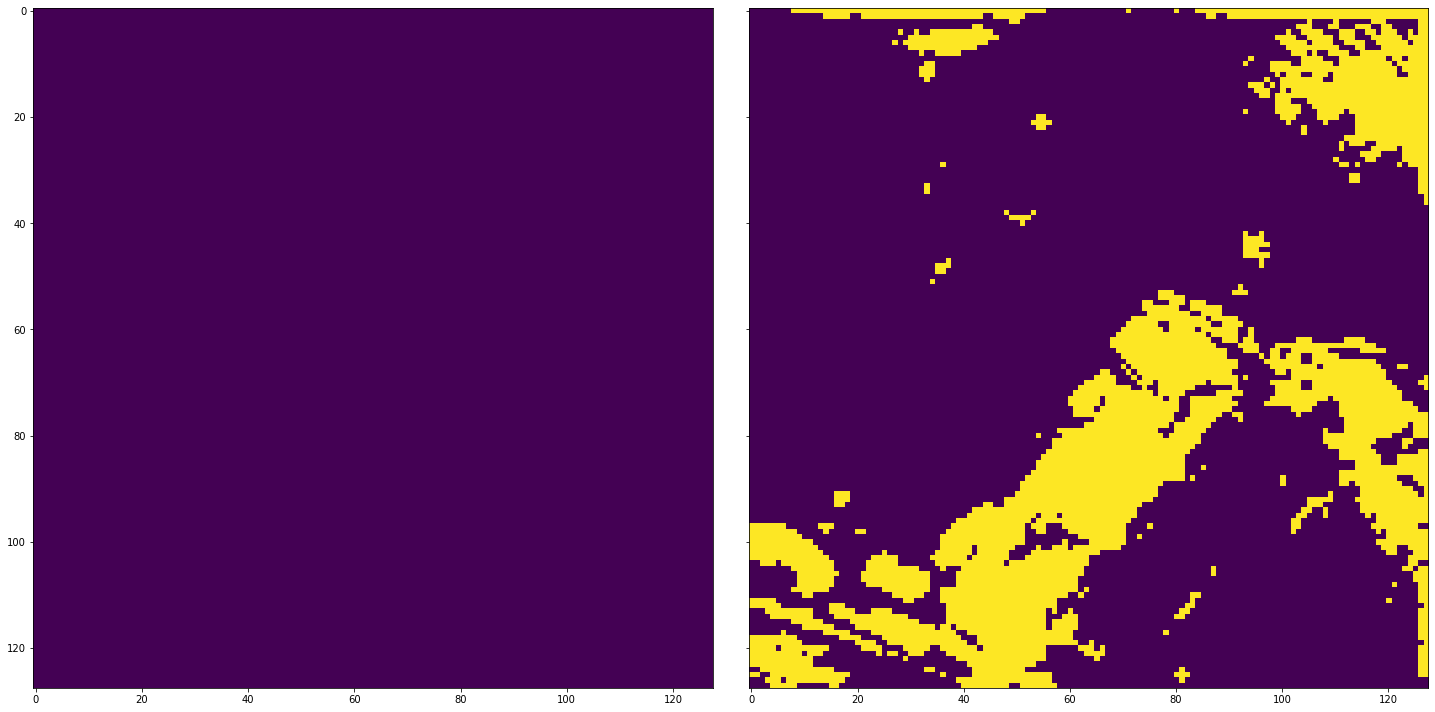

100%|██████████| 117/117 [00:14<00:00,  8.33it/s, loss=-49.4]


=> Saving checkpoint
Got 1850405/2277376 with accuracy 81.25
Dice score: 0.31082475185394287
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


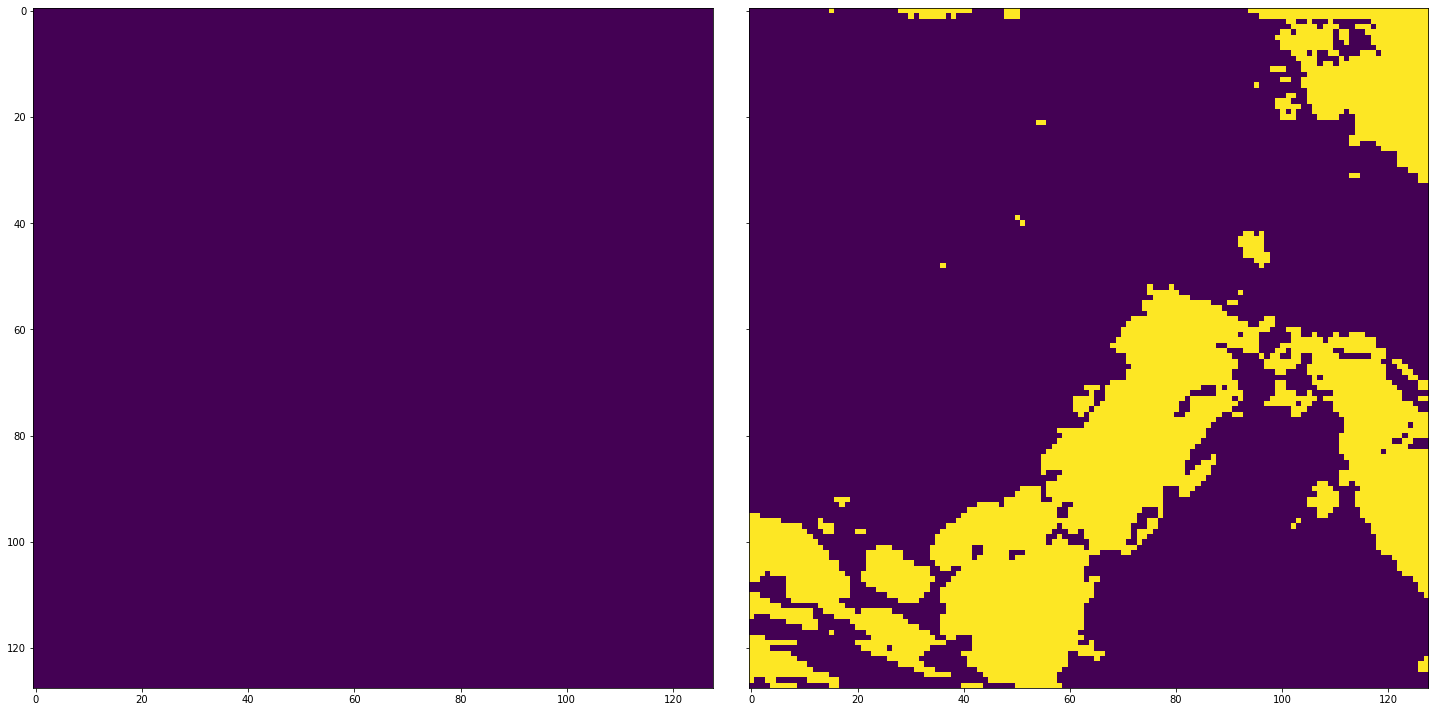

100%|██████████| 117/117 [00:14<00:00,  8.32it/s, loss=0.348]


=> Saving checkpoint
Got 2105667/2277376 with accuracy 92.46
Dice score: 0.40134814381599426
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


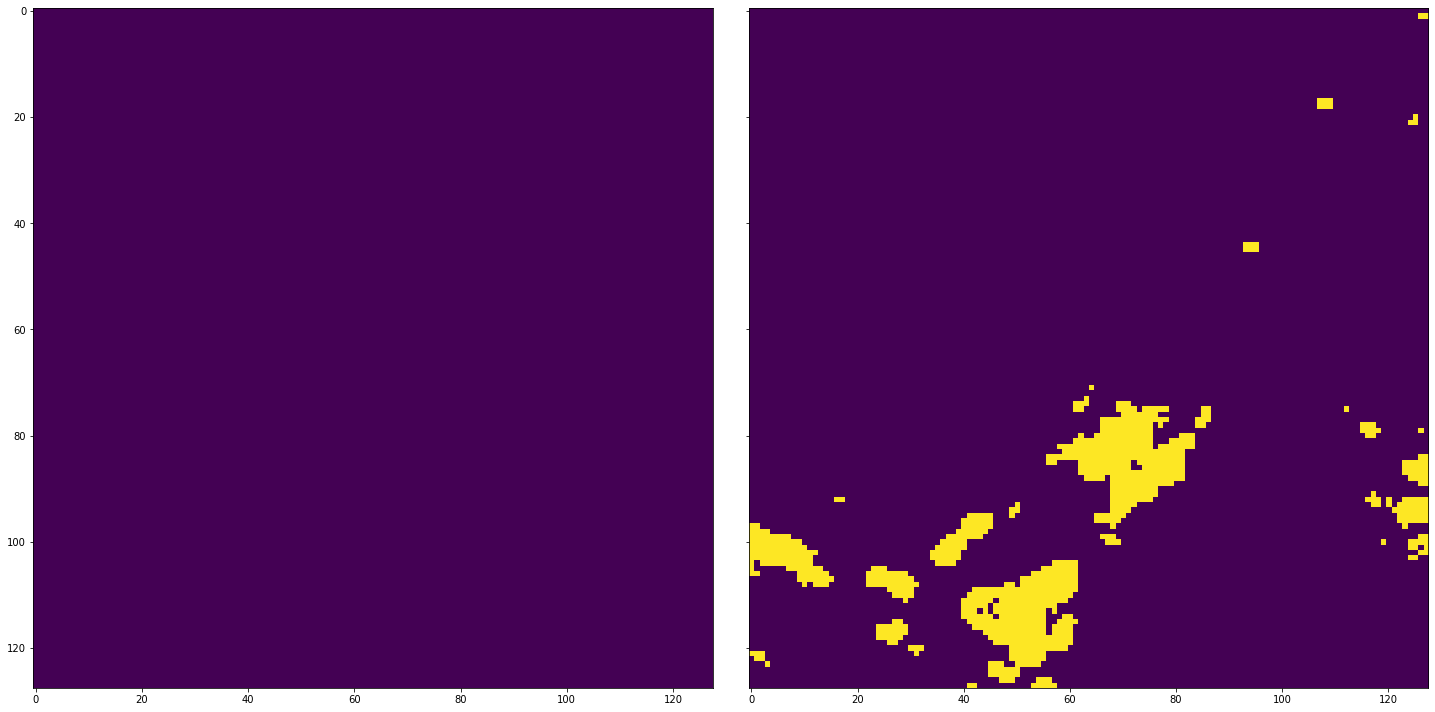

100%|██████████| 117/117 [00:14<00:00,  8.30it/s, loss=-38]


=> Saving checkpoint
Got 1962049/2277376 with accuracy 86.15
Dice score: 0.35992562770843506
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


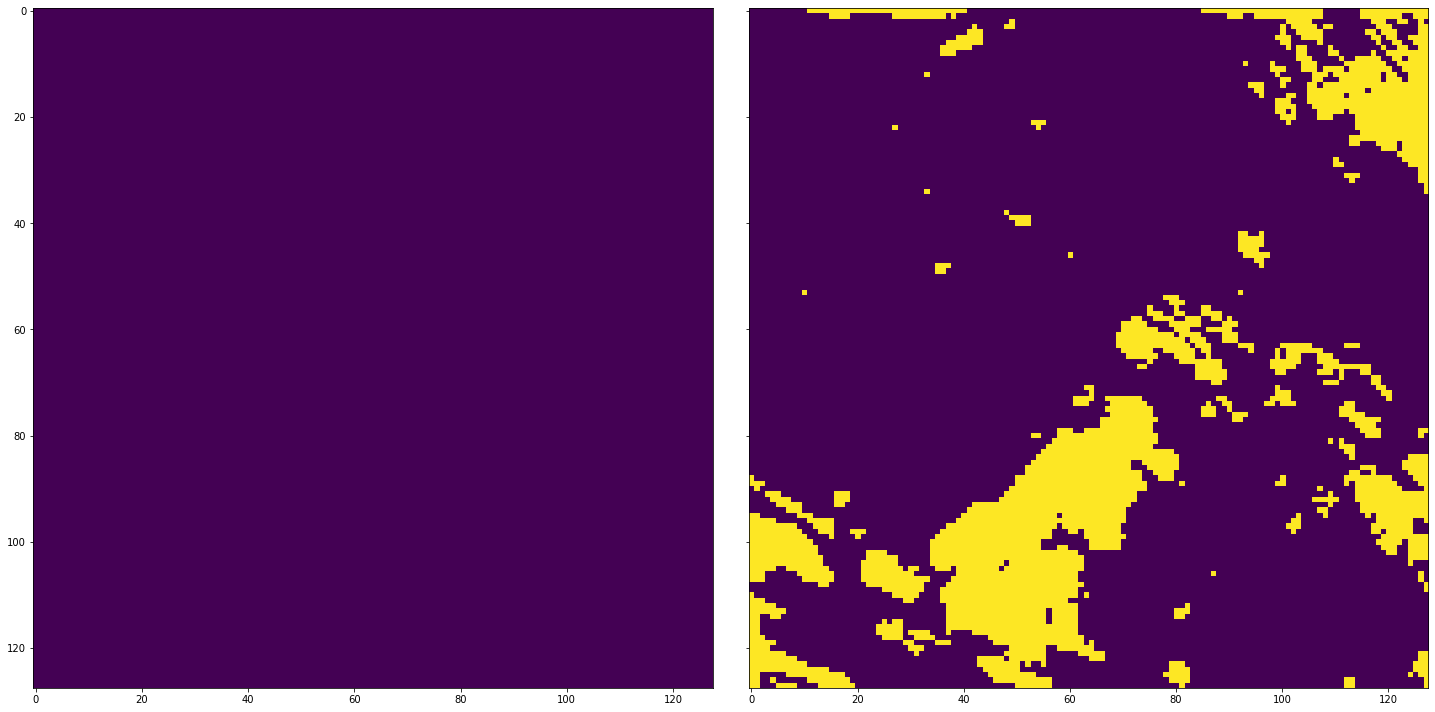

100%|██████████| 117/117 [00:14<00:00,  8.32it/s, loss=0.307]


=> Saving checkpoint
Got 1862926/2277376 with accuracy 81.80
Dice score: 0.31218409538269043
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


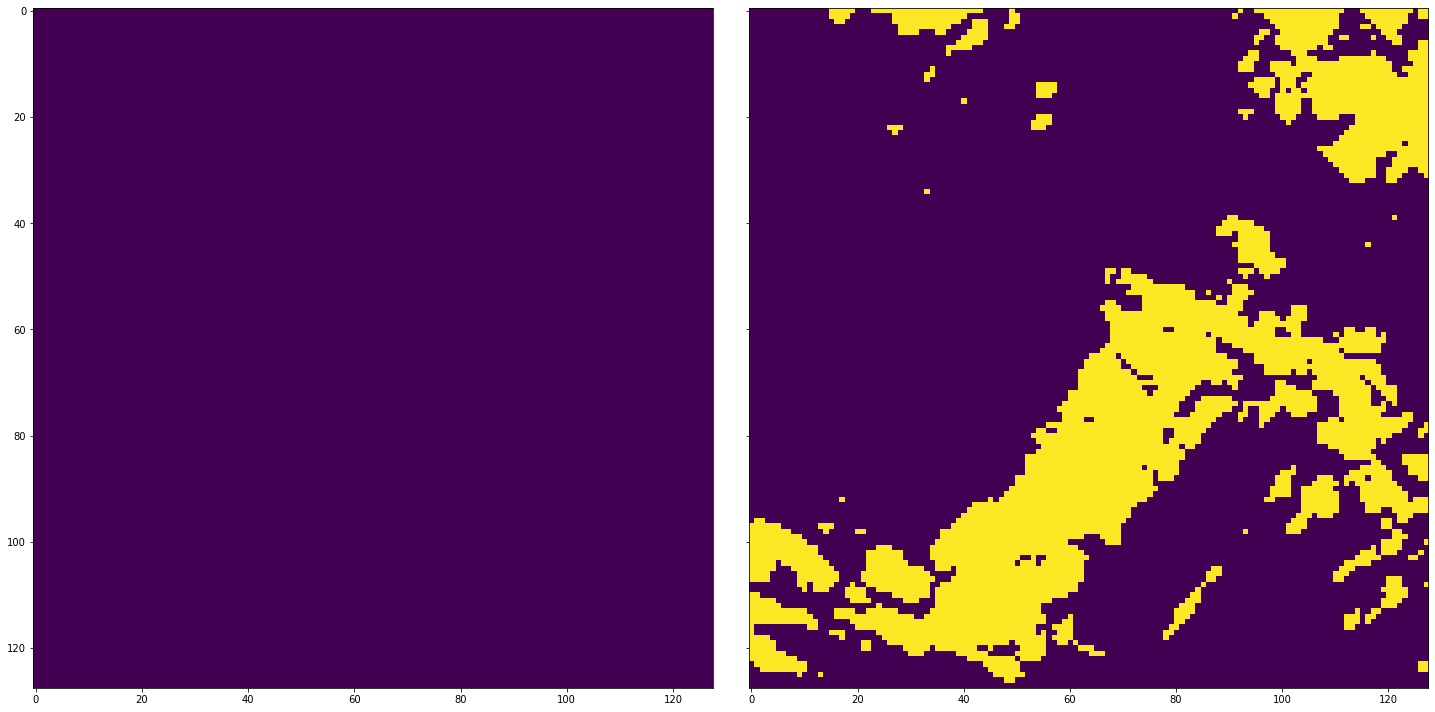

100%|██████████| 117/117 [00:13<00:00,  8.39it/s, loss=0.48]


=> Saving checkpoint
Got 2143024/2277376 with accuracy 94.10
Dice score: 0.4157836139202118
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


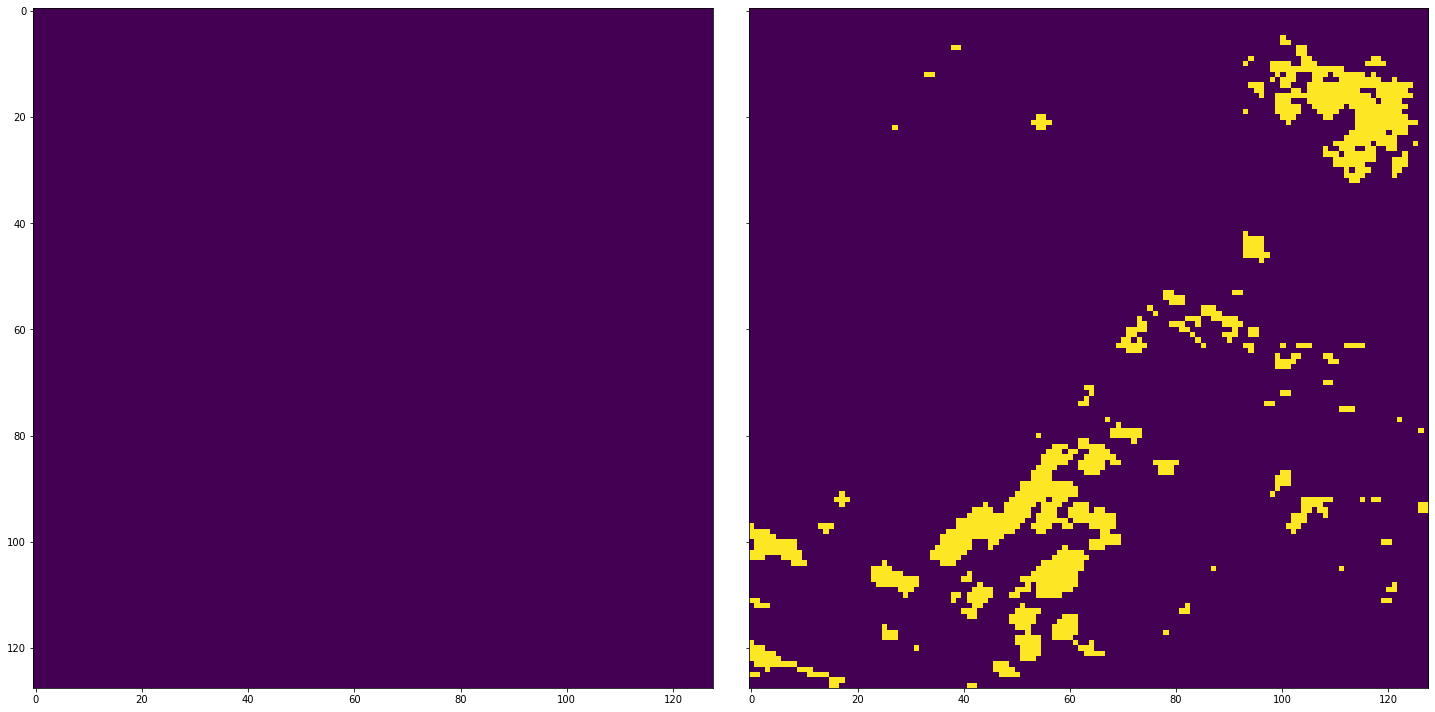

100%|██████████| 117/117 [00:14<00:00,  8.27it/s, loss=-33.4]


=> Saving checkpoint
Got 2187523/2277376 with accuracy 96.05
Dice score: 0.4281153976917267
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


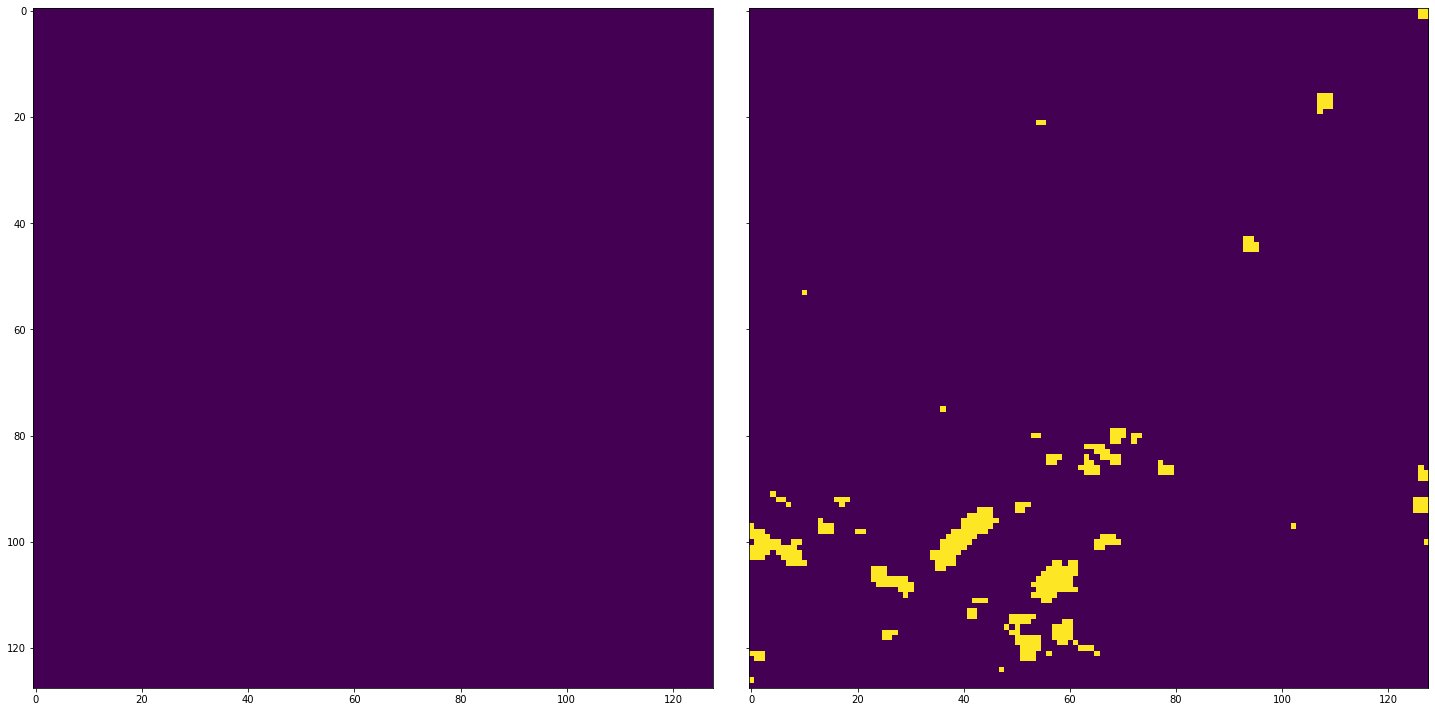

100%|██████████| 117/117 [00:14<00:00,  8.30it/s, loss=0.317]


=> Saving checkpoint
Got 2223705/2277376 with accuracy 97.64
Dice score: 0.44170713424682617
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


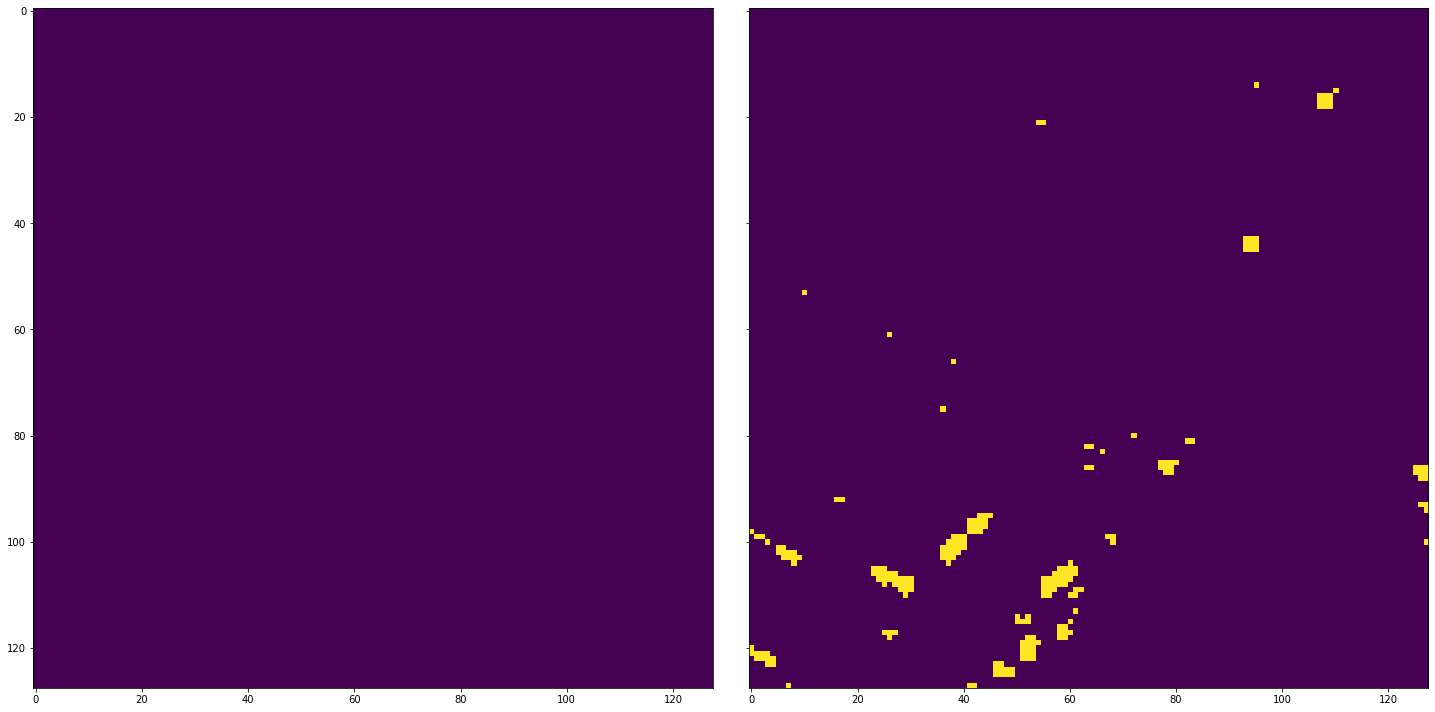

100%|██████████| 117/117 [00:13<00:00,  8.37it/s, loss=0.368]


=> Saving checkpoint
Got 2170458/2277376 with accuracy 95.31
Dice score: 0.43492814898490906
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


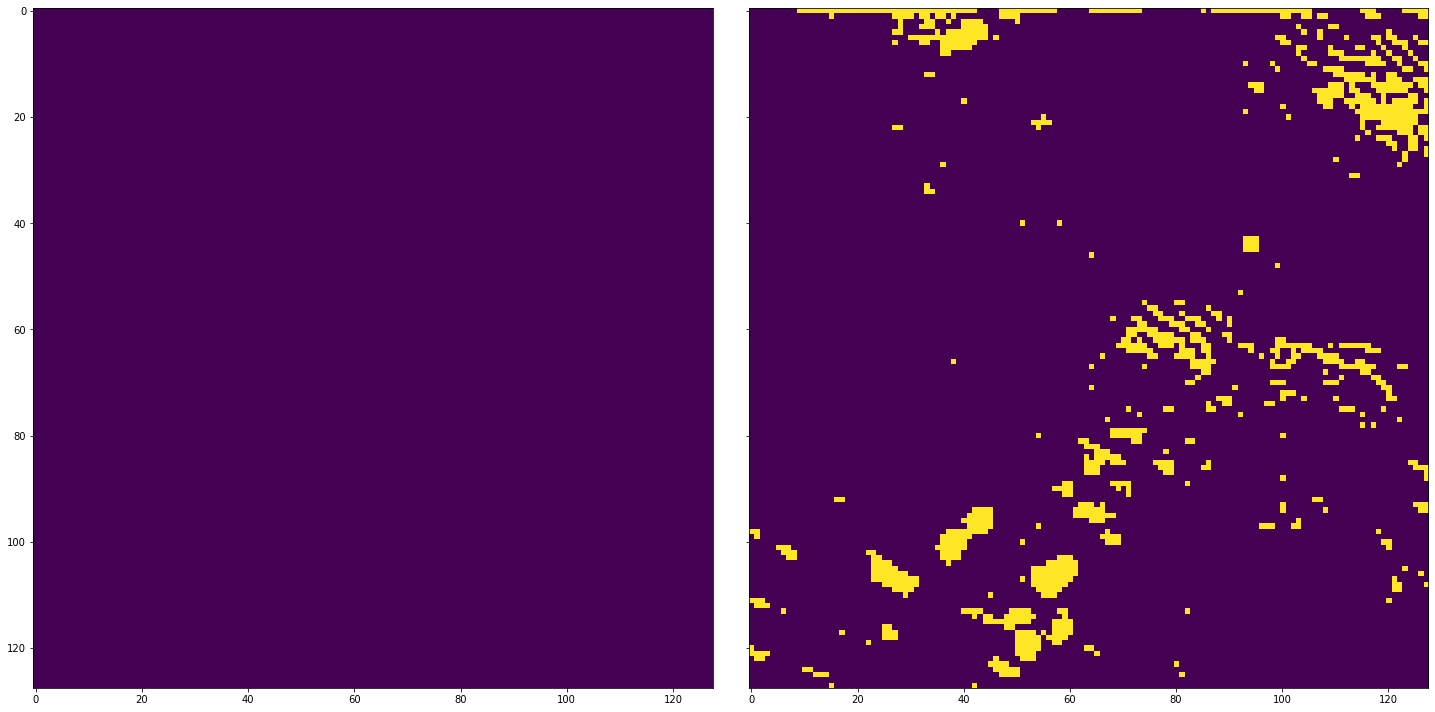

100%|██████████| 117/117 [00:14<00:00,  8.28it/s, loss=0.184]


=> Saving checkpoint
Got 2167285/2277376 with accuracy 95.17
Dice score: 0.43962007761001587
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


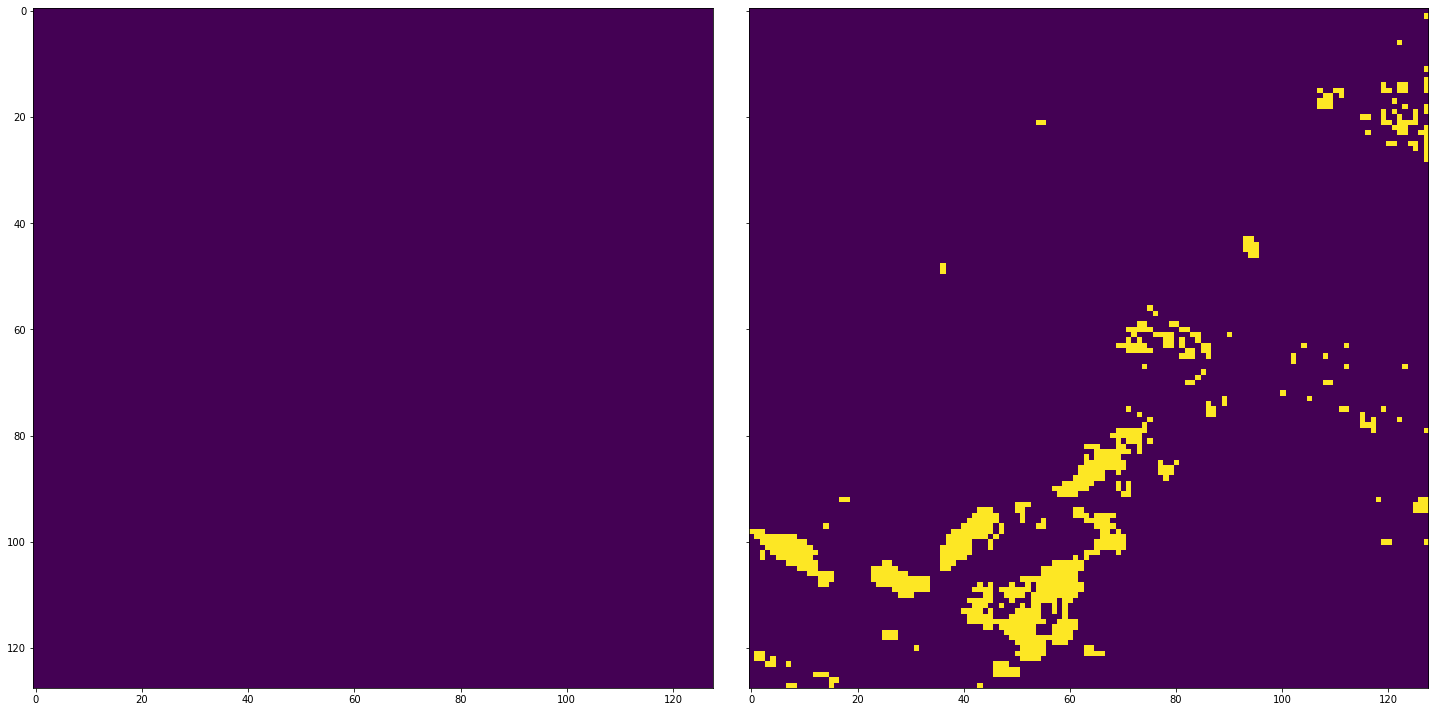

100%|██████████| 117/117 [00:14<00:00,  8.31it/s, loss=0.149]


=> Saving checkpoint
Got 2238889/2277376 with accuracy 98.31
Dice score: 0.4431593418121338
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


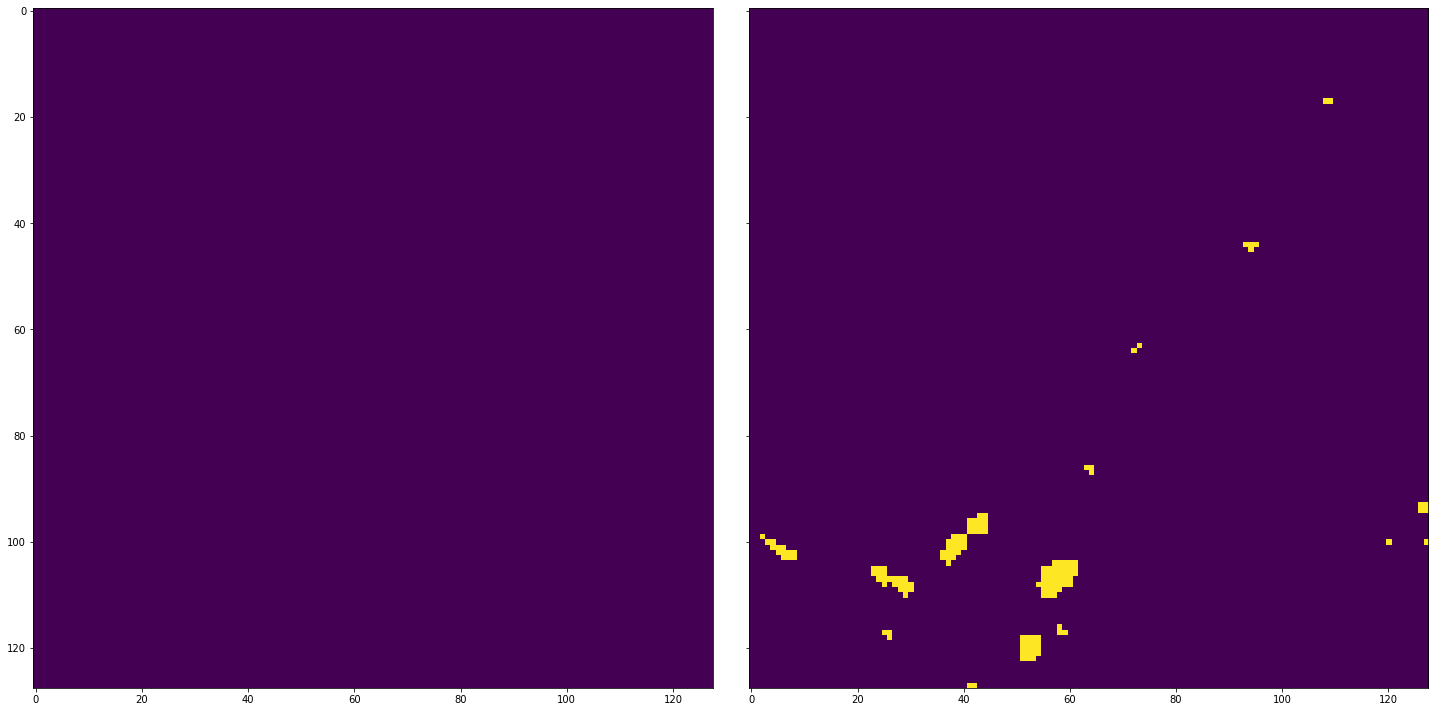

100%|██████████| 117/117 [00:13<00:00,  8.37it/s, loss=0.392]


=> Saving checkpoint
Got 2112479/2277376 with accuracy 92.76
Dice score: 0.40890833735466003
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


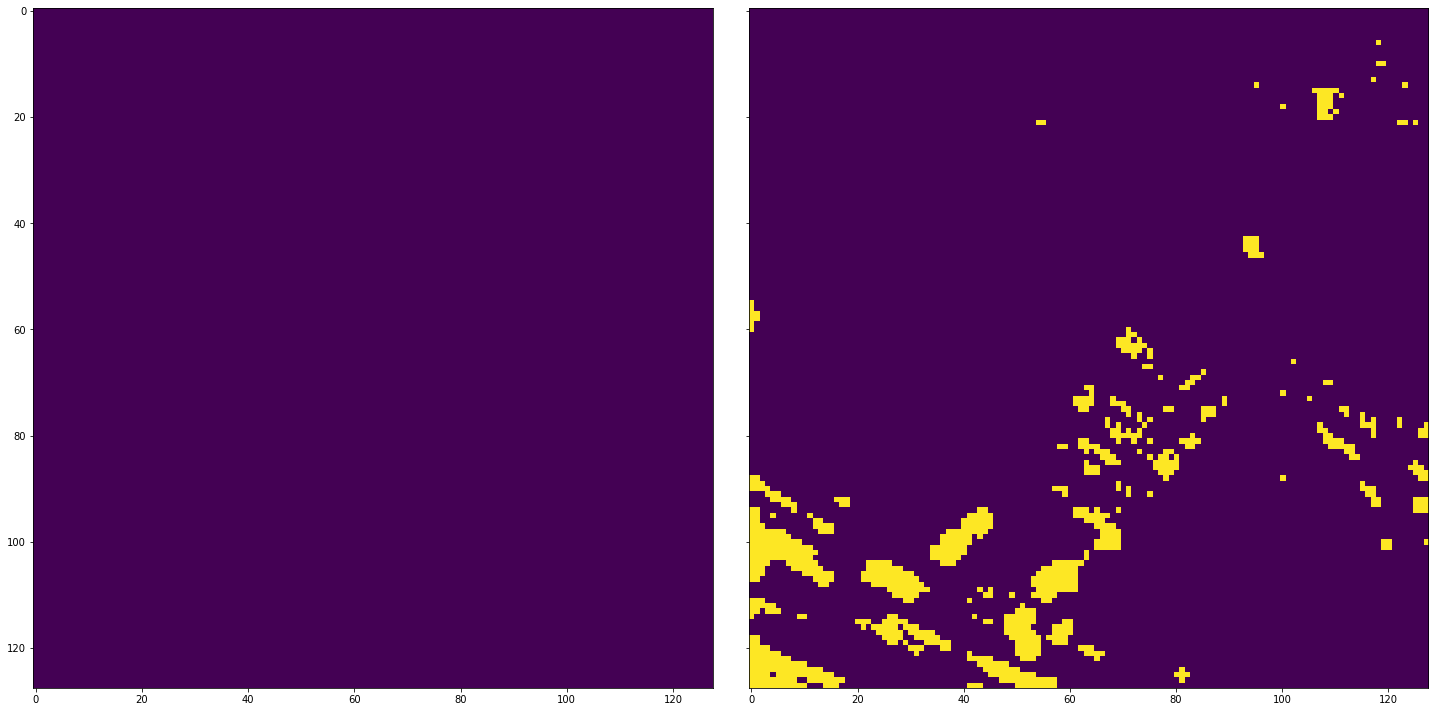

100%|██████████| 117/117 [00:14<00:00,  8.29it/s, loss=-22.6]


=> Saving checkpoint
Got 2223304/2277376 with accuracy 97.63
Dice score: 0.4522063136100769
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


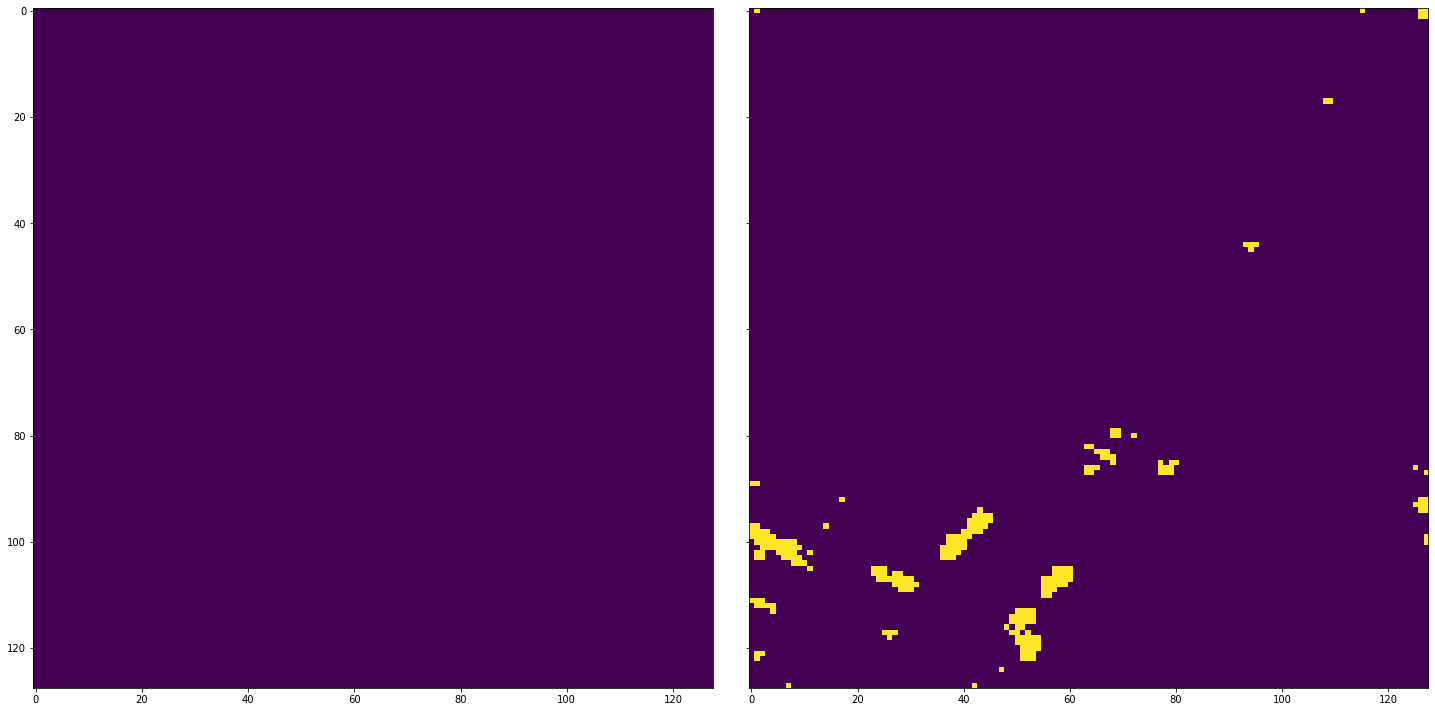

100%|██████████| 117/117 [00:14<00:00,  8.32it/s, loss=-57.4]


=> Saving checkpoint
Got 2247119/2277376 with accuracy 98.67
Dice score: 0.33857759833335876
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


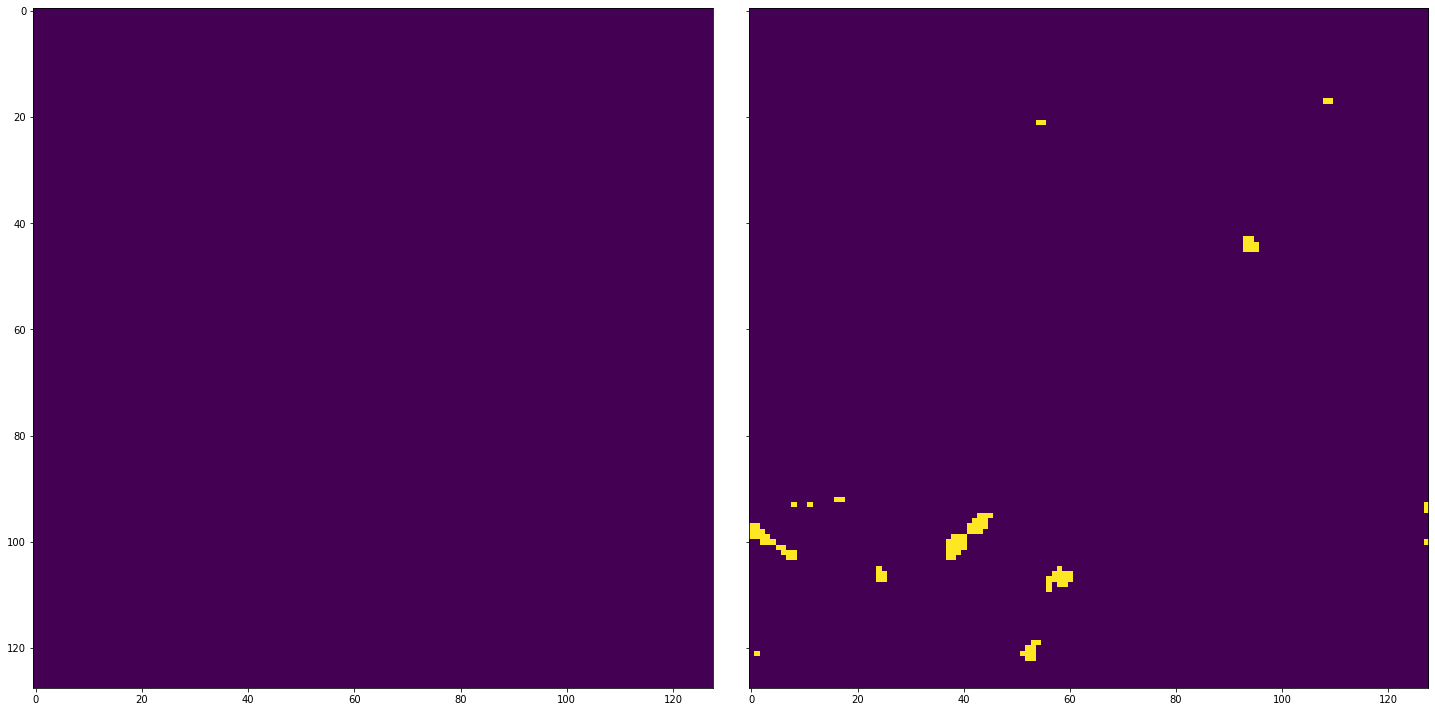

100%|██████████| 117/117 [00:14<00:00,  8.31it/s, loss=-34.5]


=> Saving checkpoint
Got 2199663/2277376 with accuracy 96.59
Dice score: 0.4573545753955841
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


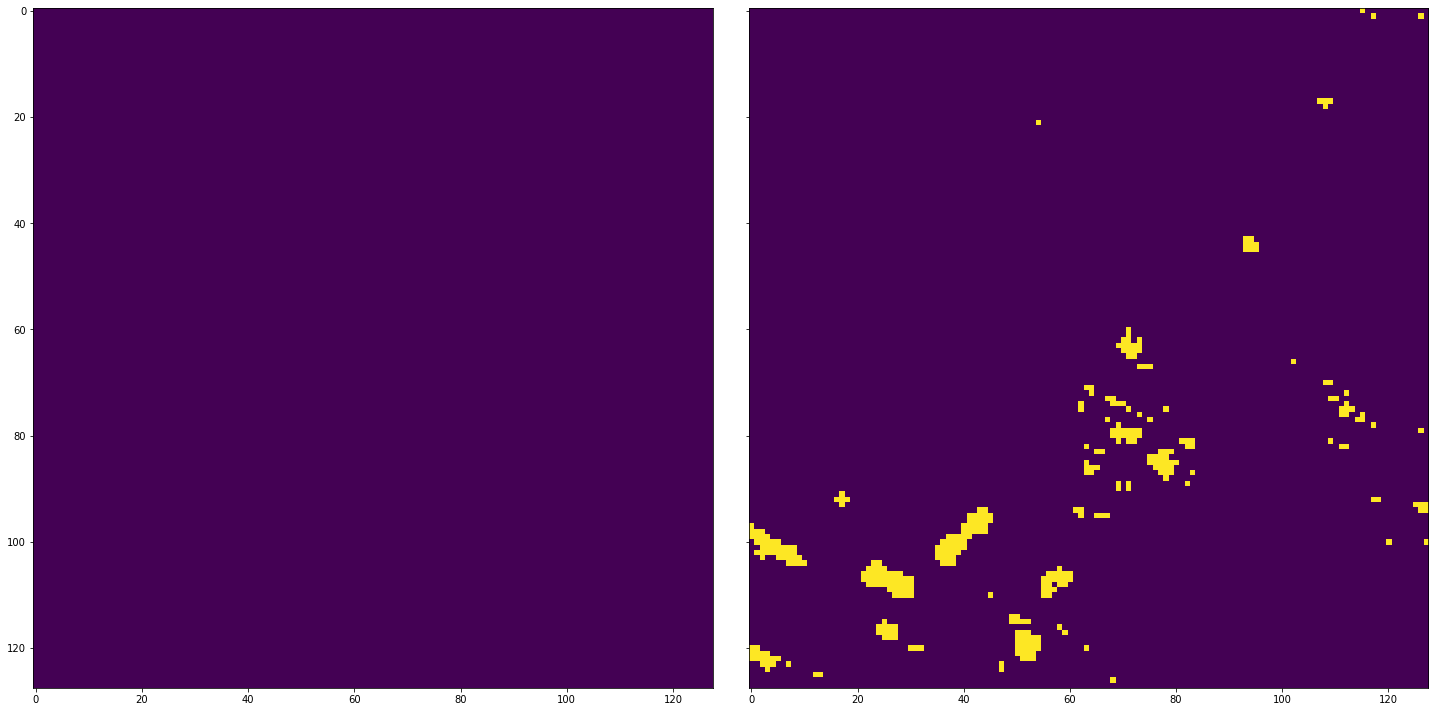

100%|██████████| 117/117 [00:14<00:00,  8.32it/s, loss=0.132]


=> Saving checkpoint
Got 2204478/2277376 with accuracy 96.80
Dice score: 0.3921831548213959
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


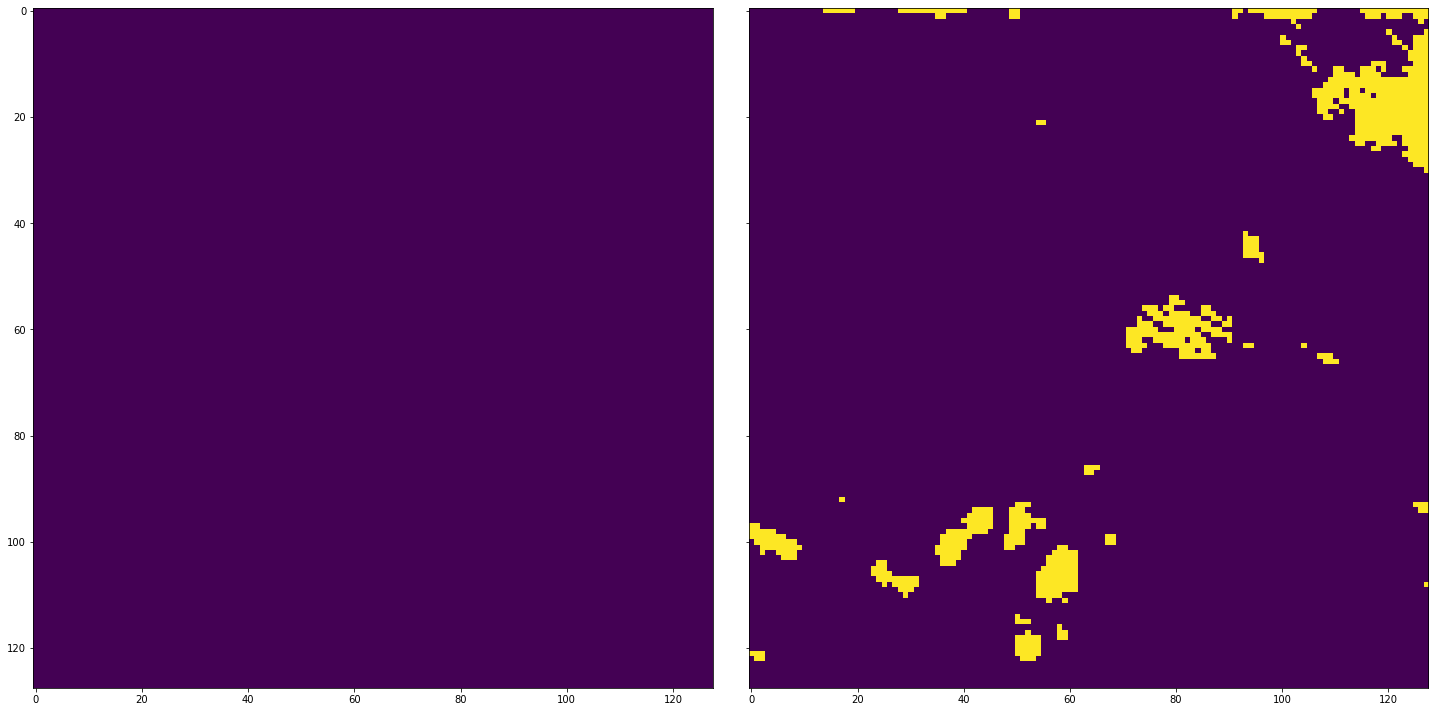

100%|██████████| 117/117 [00:14<00:00,  8.33it/s, loss=0.25]


=> Saving checkpoint
Got 2128449/2277376 with accuracy 93.46
Dice score: 0.4100838899612427
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


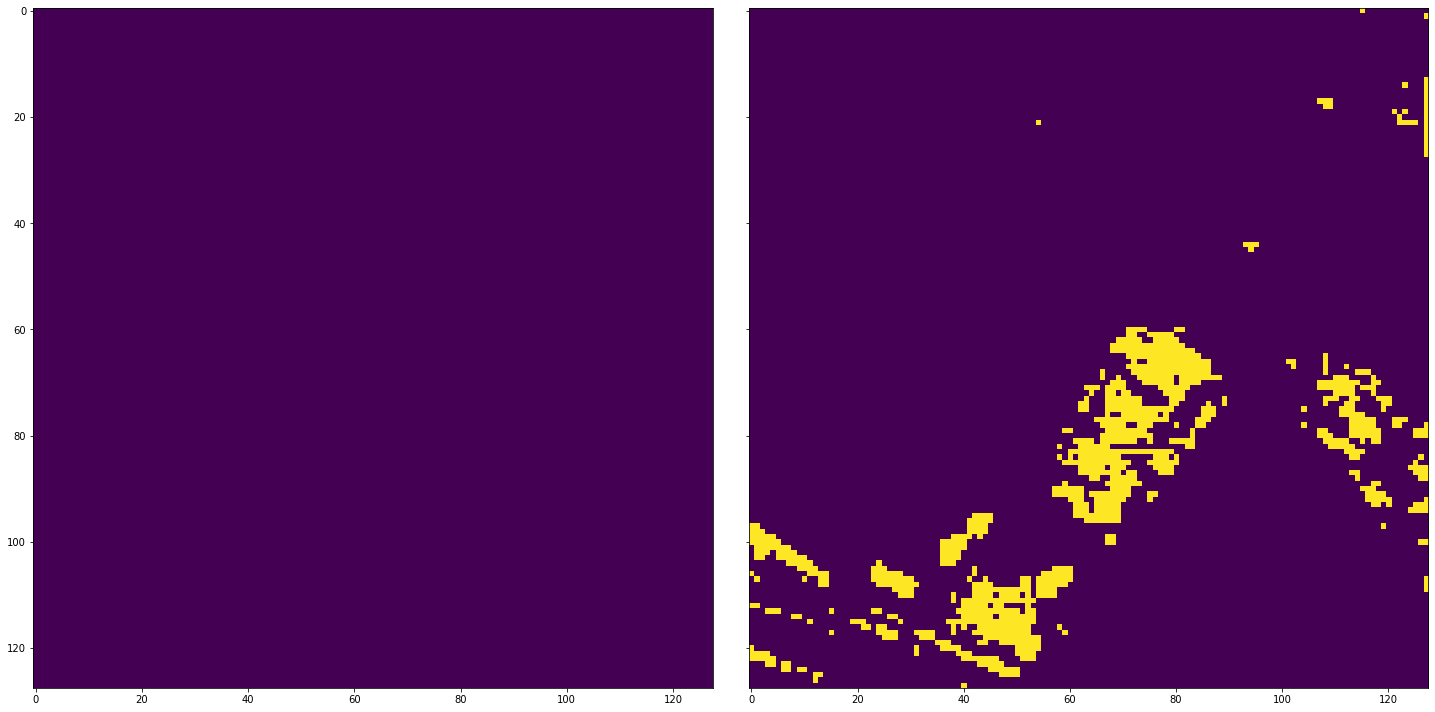

100%|██████████| 117/117 [00:14<00:00,  8.33it/s, loss=0.503]


=> Saving checkpoint
Got 1907108/2277376 with accuracy 83.74
Dice score: 0.3414888083934784
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


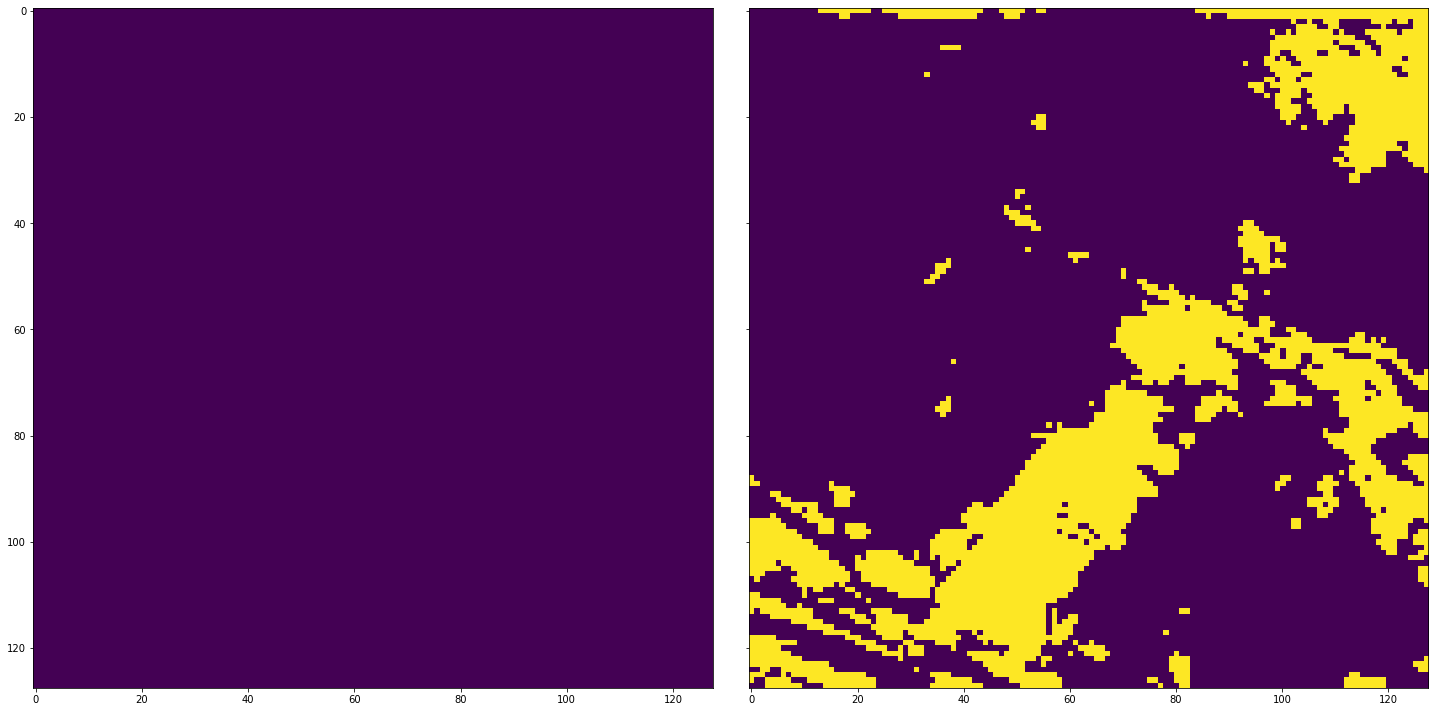

100%|██████████| 117/117 [00:14<00:00,  8.24it/s, loss=0.194]


=> Saving checkpoint
Got 2246979/2277376 with accuracy 98.67
Dice score: 0.33086106181144714
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


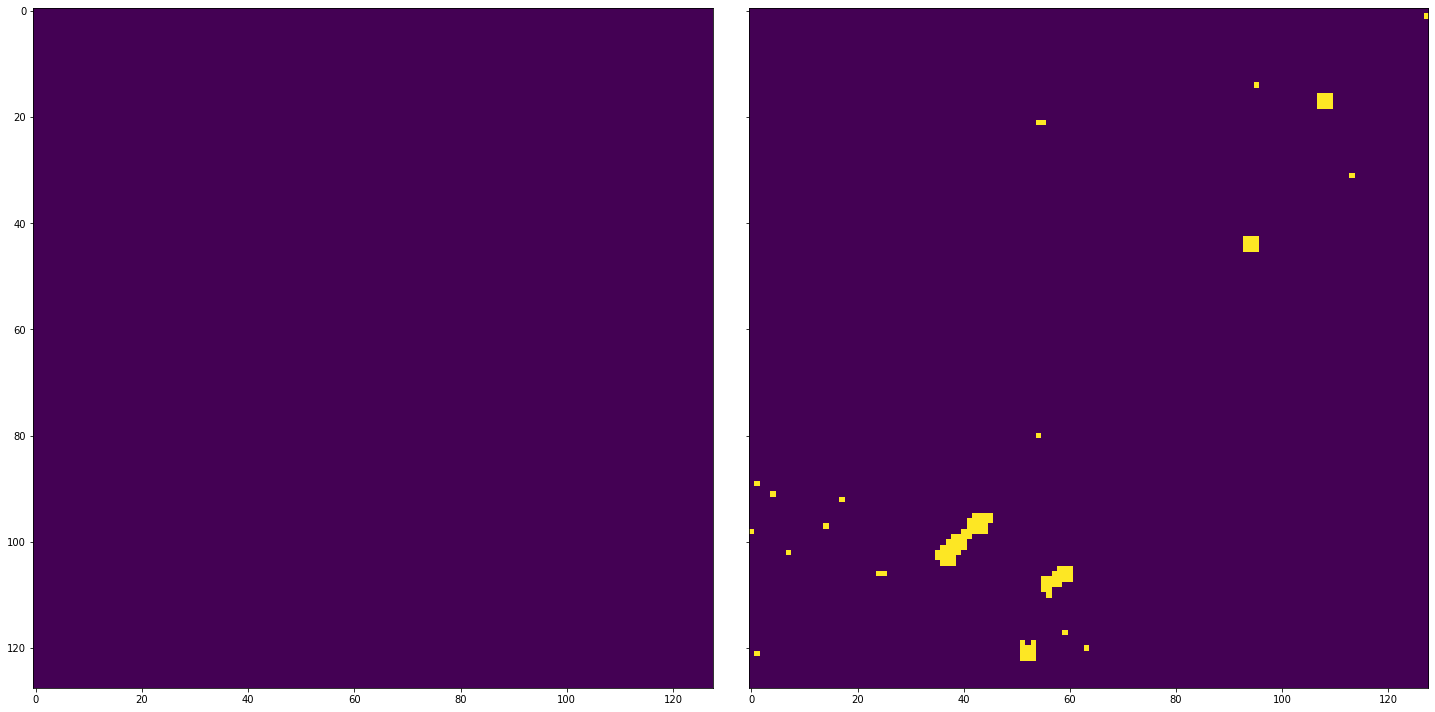

100%|██████████| 117/117 [00:14<00:00,  8.26it/s, loss=-25]


=> Saving checkpoint
Got 2153909/2277376 with accuracy 94.58
Dice score: 0.42419514060020447
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


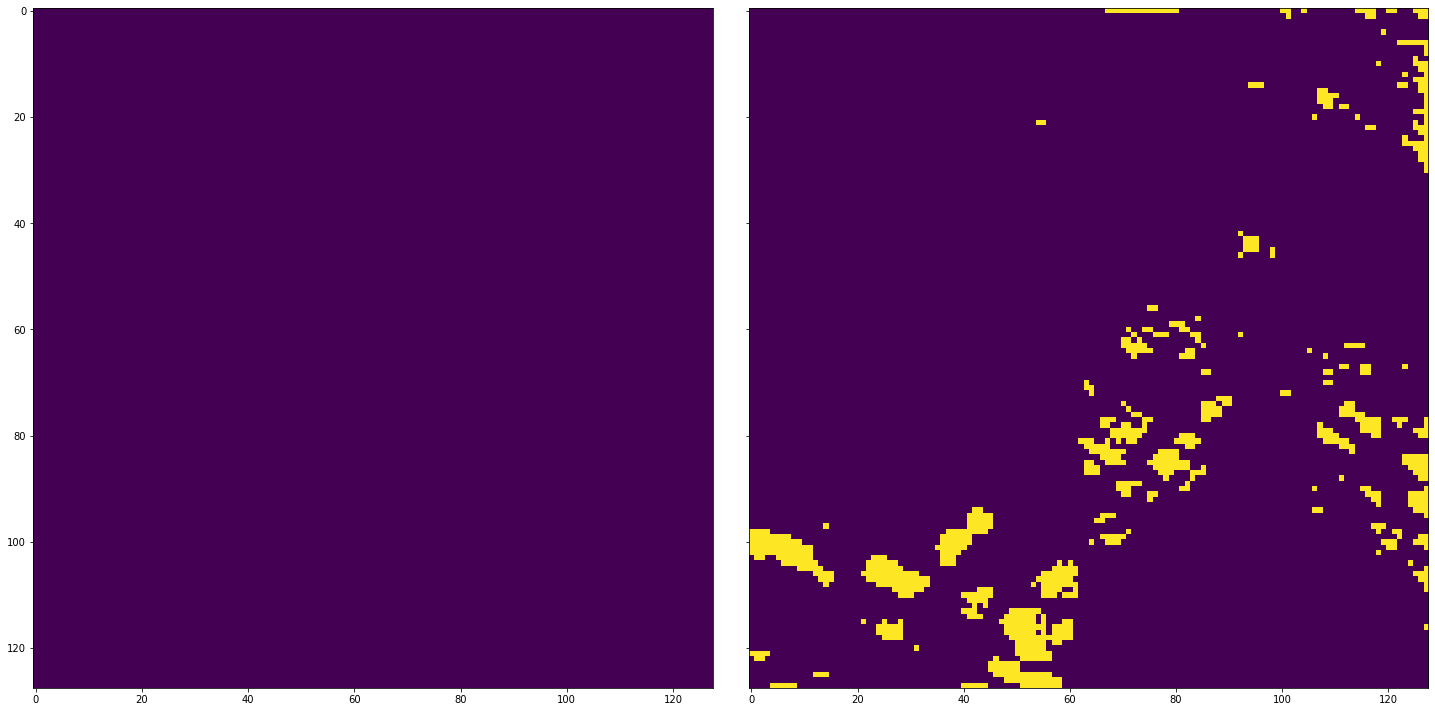

100%|██████████| 117/117 [00:14<00:00,  8.35it/s, loss=0.914]


=> Saving checkpoint
Got 2183276/2277376 with accuracy 95.87
Dice score: 0.44610923528671265
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


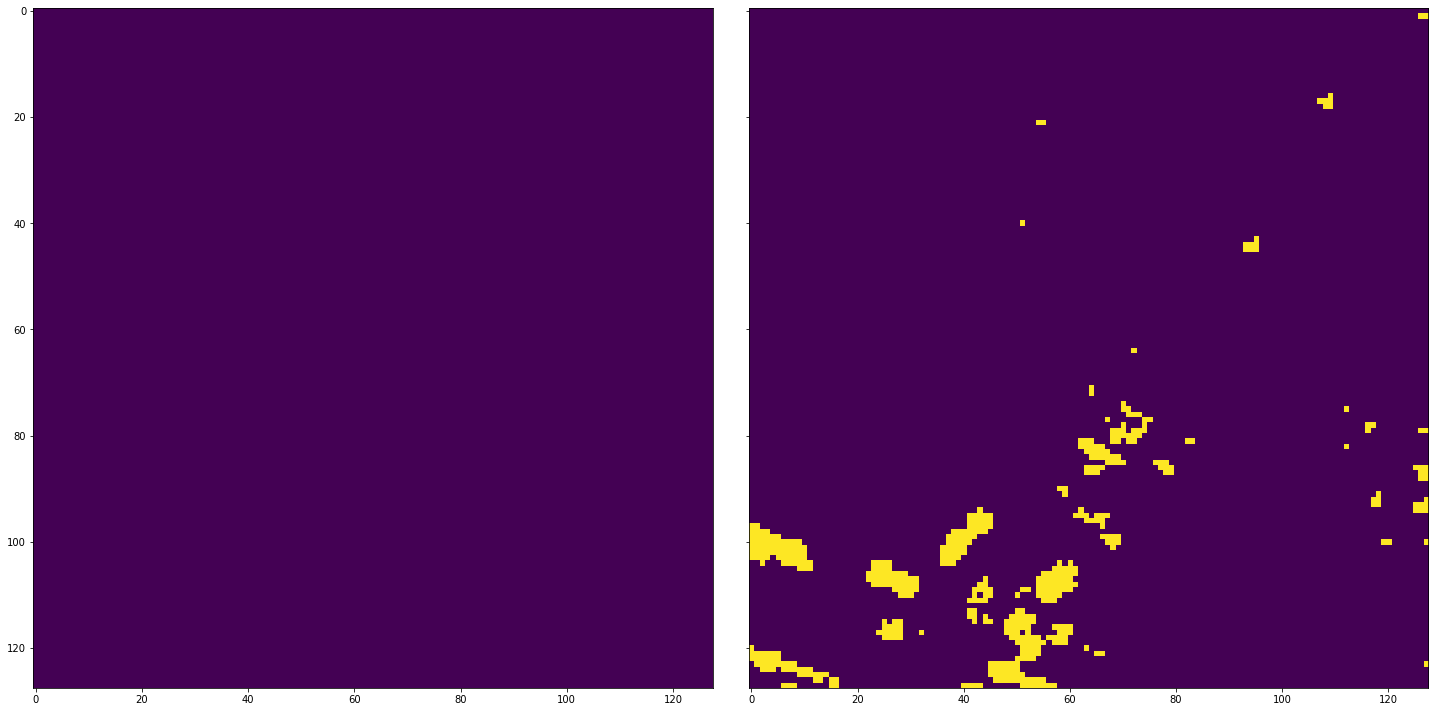

100%|██████████| 117/117 [00:14<00:00,  8.30it/s, loss=-69.8]


=> Saving checkpoint
Got 2204038/2277376 with accuracy 96.78
Dice score: 0.44333478808403015
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


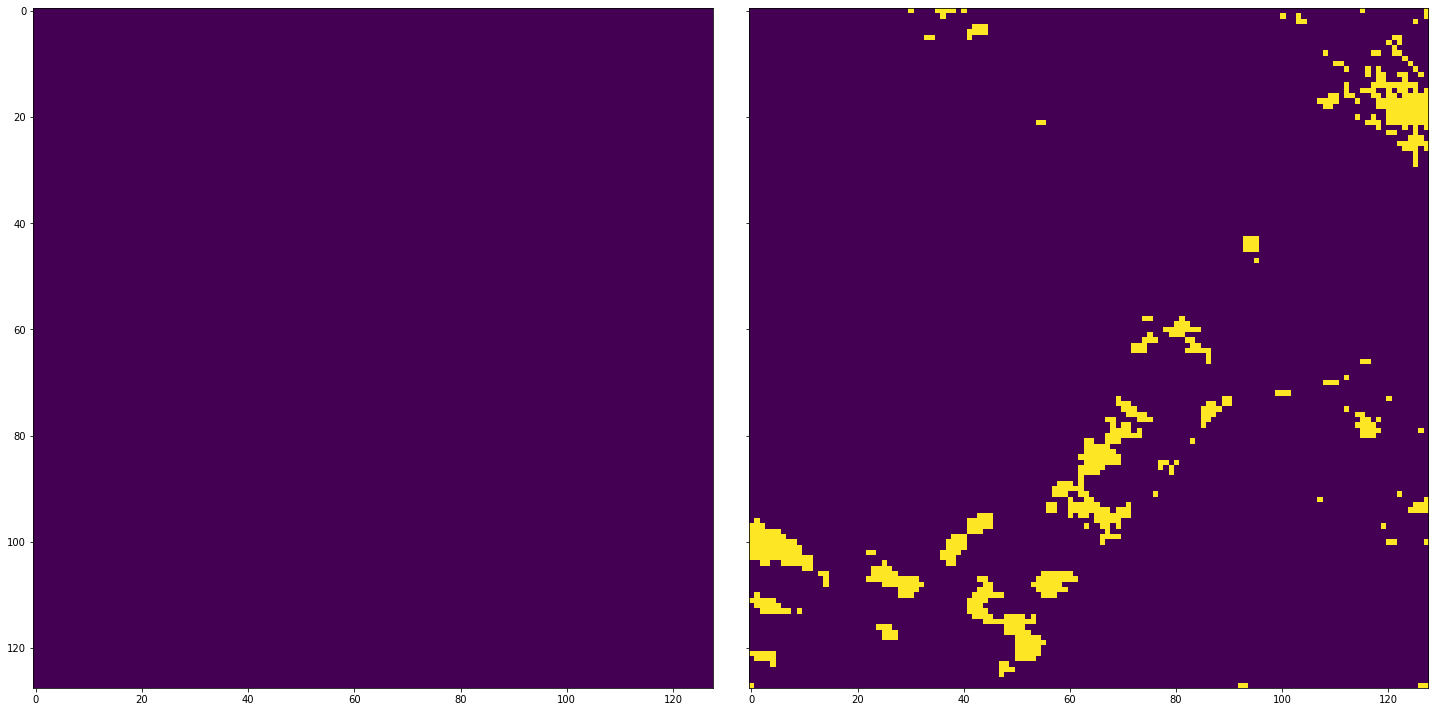

100%|██████████| 117/117 [00:14<00:00,  8.21it/s, loss=0.335]


=> Saving checkpoint
Got 2242917/2277376 with accuracy 98.49
Dice score: 0.4121078848838806
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


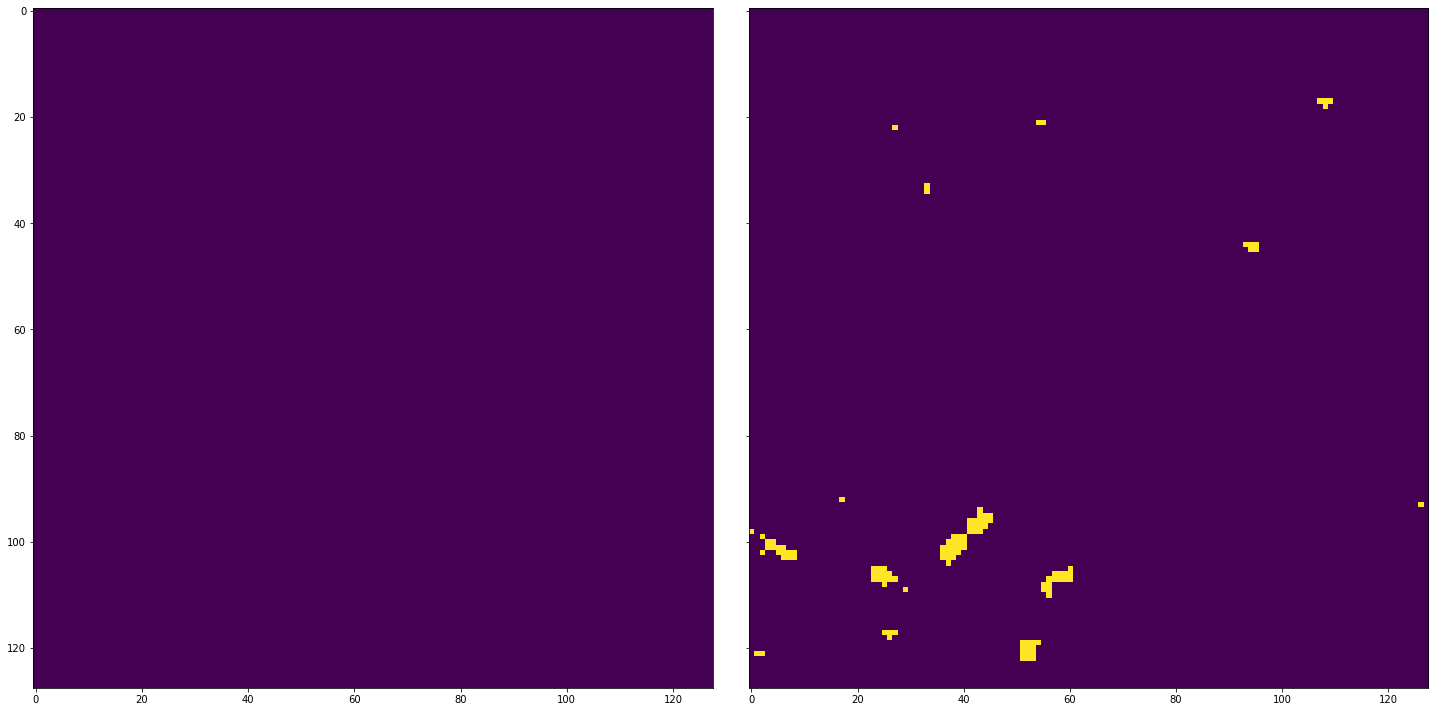

100%|██████████| 117/117 [00:14<00:00,  8.29it/s, loss=0.564]


=> Saving checkpoint
Got 2230568/2277376 with accuracy 97.94
Dice score: 0.4242595136165619
label shape: (count, width, height, channels)
a_lbl shape:  (1, 128, 128)
p_lbl shape:  (1, 128, 128)
c_lbl shape:  (2, 128, 128)


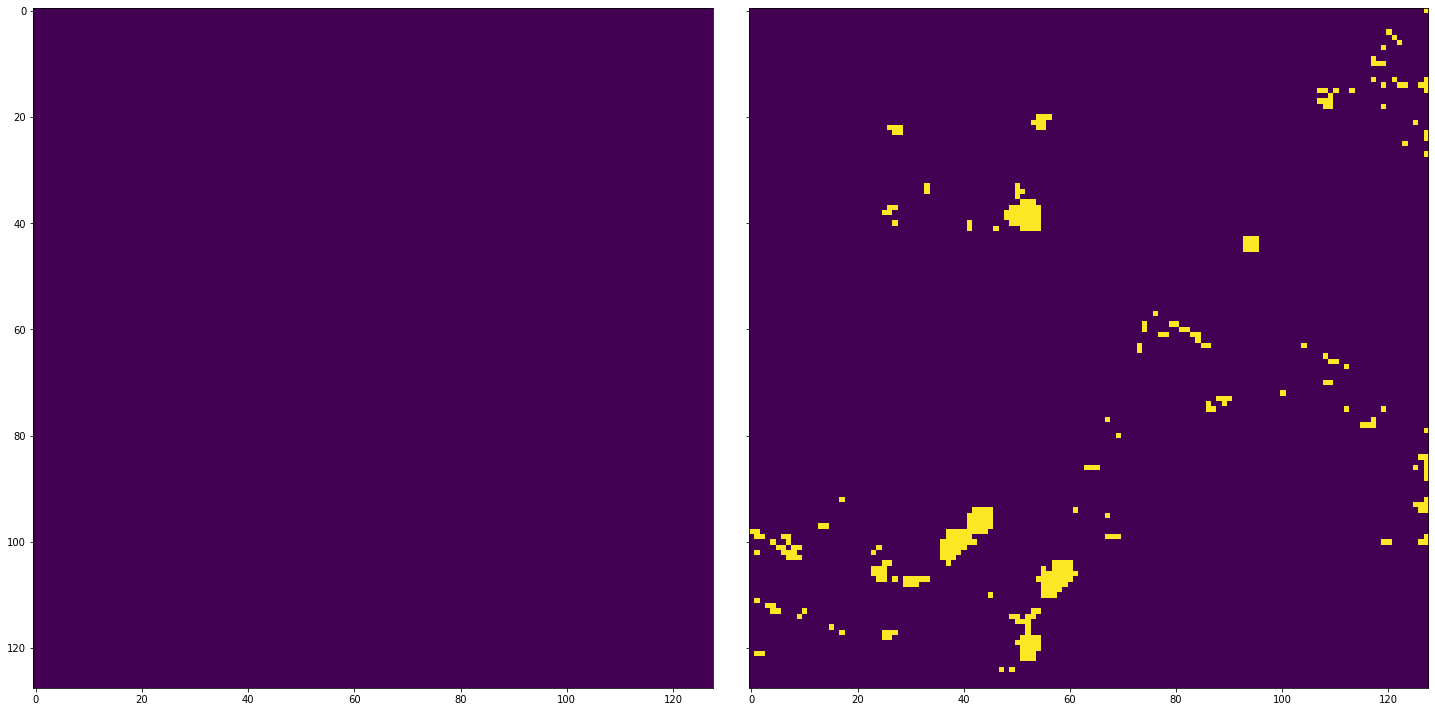

In [11]:
# Now we'll do training here
# Hyperparameters
# LEARNING_RATE  = 1e-4
# DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
# BATCH_SIZE     = 32
# NUM_EPOCHS     = 100
# NUM_WORKERS    = 2
# IMAGE_HEIGHT   = 160
# IMAGE_WIDTH    = 240
# PIN_MEMORY     = True
# LOAD_MODEL     = False

# Dataset Paths
# TRAIN_IMG_DIR  = "data/train_images/"
# TRAIN_MASK_DIR = "data/train_masks/"
# VAL_IMG_DIR    = "data/val_images/"
# VAL_MASK_DIR   = "data/val_masks/"


# This whole function trains one epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader) # tqdm gives us a progress bar

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE) #might not need to make it float since it might already be float? Also, unsqueeze is used cuz we're adding a channel

    # Forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    loop.set_postfix(loss=loss.item())




def main():
  train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0 # This basically just divides by 255, so we get a value between 0 and 1
    ),
    ToTensorV2()
  ])

  val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0 # This basically just divides by 255, so we get a value between 0 and 1
    ),
    ToTensorV2()
  ])

  model = UNet(in_channels=3, out_channels=1).to(DEVICE) # if we wanted multiclass segmentation we'd change our channels and change our loss function to cross entropy loss
  loss_fn = nn.BCEWithLogitsLoss() # We're not doing sigmoid on the output of model which is why we're using this here
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  train_loader, val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_LBL_DIR,
      VAL_IMG_DIR,
      VAL_LBL_DIR,
      BATCH_SIZE,
      train_transform,
      val_transforms,
      NUM_WORKERS,
      PIN_MEMORY
  )

  if LOAD_MODEL:
    load_checkpoint(torch.load(CHECKPOINT), model)
  check_accuracy(val_loader, model, device=DEVICE)
  scaler = torch.cuda.amp.GradScaler()
  
  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # Save Model
    checkpoint = {"state_dict":model.state_dict(), "optimizer":optimizer.state_dict()}
    save_checkpoint(checkpoint)

    # Check Accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # Save Predictions
    save_predictions_as_imgs(val_loader, model, folder=PREDICT_DIR, device=DEVICE)
    




    # TODO: display isn't working because predictions are saved in a weird concatinated format (it looks like each epoch, all predictions are saved to one file?)

    # Display
    if DISP_RESULTS:
      p_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{PREDICT_DIR}/pred_*.{IMG_FORMAT}"))][:DISP_LIMIT])
      a_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{PREDICT_DIR}/[!pred_]*.{IMG_FORMAT}"))][:p_lbls.shape[0]])
      # p_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{PREDICT_DIR}/[!pred_]*.{IMG_FORMAT}"))][:DISP_LIMIT])
      # a_lbls = np.array([np.asarray(Image.open(path).convert('L'), dtype=np.float32) for path in sorted(glob(f"{TRAIN_LBL_DIR}/*.{IMG_FORMAT}"))][:p_lbls.shape[0]])

      print("label shape: (count, width, height, channels)")
      print("a_lbl shape: ", a_lbls.shape)
      print("p_lbl shape: ", p_lbls.shape)

      # If shapes aren't equal this won't work
      c_lbls = np.array([img for arr in np.stack((a_lbls, p_lbls), axis=1) for img in arr])

      print("c_lbl shape: ", c_lbls.shape)

      n = c_lbls.shape[0]//2

      fig = plt.figure(figsize=(c_lbls.shape[1]//DISP_SCALE, c_lbls.shape[2]//DISP_SCALE))
      grid = ImageGrid(fig, 111, nrows_ncols=(n, 2), axes_pad=0.5)

      for ax, im in zip(grid, c_lbls):
        ax.imshow(im)

      plt.show()
    else:
      print("Must set batch size to 1 to display")





# This solves issues when running on Windows (issues relating to NUM_WORKERS)
if __name__ == "__main__":
  main()